In [ ]:
#@title Imports
import os
import json
import torch
import pathlib
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils.prune as prune
from torch.optim.lr_scheduler import StepLR
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import copy
from tqdm import tqdm
from IPython.display import HTML, display
import pickle
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import jpeg4py as jpeg
import imghdr
import h5py
from torch import nn
from datetime import datetime as dt
import warnings
from torch.optim import lr_scheduler
import re
from torchvision import transforms, utils
from PIL import Image
import sys
from matplotlib.pyplot import imshow
from torch.utils.tensorboard import SummaryWriter

#Download Data (requires memory + time)

In [ ]:
#download data (images take around 10 minutes total)
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip #training annotations
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip #validation annotations
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip #training questions
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip #validation questions
!wget http://images.cocodataset.org/zips/train2014.zip #training images
!wget http://images.cocodataset.org/zips/val2014.zip #val images

--2022-04-29 02:22:33--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.84.27
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.84.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21708861 (21M) [application/zip]
Saving to: ‘v2_Annotations_Train_mscoco.zip’

v2_Annotations_Trai 100%[===================>]  20.70M  16.2MB/s    in 1.3s    

2022-04-29 02:22:35 (16.2 MB/s) - ‘v2_Annotations_Train_mscoco.zip’ saved [21708861/21708861]

--2022-04-29 02:22:35--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.84.27
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.84.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10518930 (10M) [application/zip]
Saving to: ‘v2_Annotations_Val_mscoco.zip’

v2_Annotations_Val_ 100%[===================>]  10.03M  29.3MB/s  

In [ ]:
!unzip -q v2_Annotations_Train_mscoco.zip -d /content/v2_Annotations_Train_mscoco
!rm -rf v2_Annotations_Train_mscoco.zip

!unzip -q v2_Annotations_Val_mscoco.zip -d /content/v2_Annotations_Val_mscoco
!rm -rf v2_Annotations_Val_mscoco.zip

!unzip -q v2_Questions_Train_mscoco.zip -d /content/v2_Questions_Train_mscoco
!rm -rf v2_Questions_Train_mscoco.zip

!unzip -q v2_Questions_Val_mscoco.zip -d /content/v2_Questions_Val_mscoco
!rm -rf v2_Questions_Val_mscoco.zip

In [ ]:
!unzip -q train2014.zip
!rm -rf train2014.zip

!unzip -q val2014.zip
!rm -rf val2014.zip

#Load Data

In [ ]:
# loading data paths to variables
annotations_train_json = 'v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json'
annotations_val_json = 'v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json'
questions_train_json = 'v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json'
questions_val_json = 'v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json'
questions_test_json = 'v2_Questions_Test_mscoco/v2_OpenEnded_mscoco_test2015_questions.json'
images_train_folder = 'train2014'
images_val_folder = 'val2014'
images_test_folder = 'test2014'

In [ ]:
# loading json files as json lists
train_questions_list = json.load(open(questions_train_json))
val_questions_list = json.load(open(questions_val_json))
train_annotations_list = json.load(open(annotations_train_json))
val_annotations_list = json.load(open(annotations_val_json))

In [ ]:
# extracting questions, answers, multiple_choice_answer and answer type
train_list = train_questions_list['questions'][:10000]
val_list = val_questions_list['questions'][:2000]

for i in range(len(train_list)):
    train_list[i]['multiple_choice_answer'] = train_annotations_list['annotations'][i]['multiple_choice_answer']
    train_list[i]['answers'] = train_annotations_list['annotations'][i]['answers']
    train_list[i]['answer_type'] = train_annotations_list['annotations'][i]['answer_type']


for i in range(len(val_list)):
    val_list[i]['multiple_choice_answer'] = val_annotations_list['annotations'][i]['multiple_choice_answer']
    val_list[i]['answers'] = val_annotations_list['annotations'][i]['answers']
    val_list[i]['answer_type'] = val_annotations_list['annotations'][i]['answer_type']

In [ ]:
with open('train_val_lists.pkl', 'wb') as f:
    pickle.dump([train_list, val_list], f)

{'answer_type': 'other',
 'answers': [{'answer': 'frisbee', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'frisbee', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'frisbee', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'frisbee', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'frisbee', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'frisbee', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'frisbee', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'frisbee', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'frisbee', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'frisbee', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 524291,
 'multiple_choice_answer': 'frisbee',
 'question': 'Is the dog looking at a tennis ball or frisbee?',
 'question_id': 524291002}

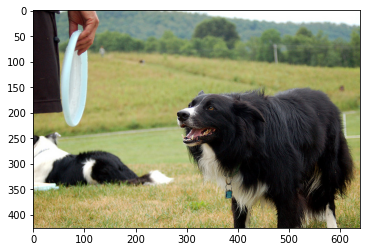

In [ ]:
imshow(Image.open('train2014/COCO_train2014_'+str(train_list[9]['image_id']).rjust(12, '0')+'.jpg'))

train_list[9]

#Get Image Features

In [ ]:
#%load extract_vgg_features.py


transform = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)])

class ImageDataset(Dataset):
    def __init__(self, json_list, split):
        self.imgids = list(set([i['image_id'] for i in json_list]))
        self.split = split

    def __len__(self):
        return len(self.imgids)

    def __getitem__(self, index):
        '''
        returns 2 tensors: image features tensor, imgid tensor.
        '''
        file = self.split+'2014/COCO_'+self.split+'2014_'+str(self.imgids[index]).rjust(12, '0')+'.jpg'
        if(imghdr.what(file) == 'jpeg'):
            item = {'image': transform(Image.fromarray(jpeg.JPEG(file).decode()))}
        else:
            item = {'image': transform(Image.open(file).convert('RGB'))}

        item['id'] = self.imgids[index]
        return item

def getFeatures(workers, batch, split):

    num_workers = workers
    batch_size = batch

    # loading the pytorch pretrained vgg 19 batchnormalized model
    w_vgg19 =  models.vgg19_bn(pretrained = True)

    # This keeps only first layer in classifier class in the model 
    w_vgg19.classifier = nn.Sequential(*list(w_vgg19.classifier.children()))[:-3]

    # setting vgg19 to evaluation mode and transfer to GPU.
    model = w_vgg19.eval().to('cuda')


    with open('train_val_lists.pkl', 'rb') as f:
        train_list, val_list = pickle.load(f)

    if(split == 'train'):
        list_json = train_list

    if(split == 'val'):
        list_json = val_list


    img_loader = DataLoader(
        ImageDataset(list_json, split),
        batch_size= batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=True,
        )

    del train_list
    del val_list
    del list_json

    model.to('cuda')
    model.eval()
    
    with h5py.File(img_loader.dataset.split+'_imgs_vgg.h5', libver='latest', mode = 'w') as f:
        img_features = f.create_dataset('img_features', shape=(len(img_loader.dataset), 4096), dtype='float16')
        img_ids = f.create_dataset('img_ids', shape=(len(img_loader.dataset),), dtype='int32')

        i = j = 0
        for data in tqdm(img_loader):
            imgs = data['image'].to('cuda')
            with torch.no_grad():
                out = model(imgs)

            j = i + imgs.size(0)
            img_features[i:j, :] = out.cpu().numpy().astype('float16')
            img_ids[i:j] = data['id'].numpy().astype('int32')
            i = j


In [ ]:
# num_workers = 4, batch_size = 64, split = 'train'
getFeatures(4, 64, "train")

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 30/30 [00:31<00:00,  1.05s/it]


In [ ]:
# num_workers = 4, batch_size = 64, split = 'val'
getFeatures(4, 64, "val")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


In [ ]:
img_feat_dict_train = {}
img_feat_dict_val = {}

img_h5 = h5py.File('train_imgs_vgg.h5', libver='latest', mode = 'r')
img_features = img_h5['img_features']
img_ids_list = list(img_h5['img_ids'])
for i in range(len(img_ids_list)):
    img_feat_dict_train[img_ids_list[i]] = img_features[i]

img_h5 = h5py.File('val_imgs_vgg.h5', libver='latest', mode = 'r')
img_features = img_h5['img_features']
img_ids_list = list(img_h5['img_ids'])
for i in range(len(img_ids_list)):
    img_feat_dict_val[img_ids_list[i]] = img_features[i]

with open('img_feats_dicts_vgg19.pickle', 'wb') as f:
    pickle.dump(img_feat_dict_train, f)
    pickle.dump(img_feat_dict_val, f)

#Helper Functions

In [ ]:

def tokenize(sentence):
    '''
    splits the sentence at whitespaces, any special characters like , ? / etc
    and outputs a list of tokens
    '''
    sentence = sentence.lower()
    return [i for i in re.split(r"([-!\$#.\"',:? @~();\[\]/\\\+<>\n*&\^%=])", sentence) if
            i != '' and i != ' ' and i != '\n']

def create_question_vocab(qa_list):
    '''
    Creates vocabulary for given json formatted dataset
    '''
    # appending pad and unknown characters to vocab 
    vocab = ['<PAD>', '<UNK>']  
    
    # obtaining unique words from the data 
    vocab += sorted(list(set([w for q in qa_list for w in tokenize(q['question'])])))
    
    # making a dict to get its index quickly
    vocab_dict = {}
    for i in range(len(vocab)):
        vocab_dict[vocab[i]] = i 
        
    return vocab_dict
            
def encode_questions(qa_list, question_vocab, max_length = 25):
    '''
    Given data json and vocab. This function encodes each question into 25 length list
    
    '''
    encoded_questions = []
    
    #converting each token in question to id using vocab dict
    questions_to_ids = [[question_vocab.get(i, question_vocab['<UNK>']) for i in tokenize(q['question'])] for q in qa_list]
    
    #padding 0s if length is <25 and truncating if it exceeds 25.
    for q in questions_to_ids:
        length = len(q)
        if(length < max_length):
            q += [question_vocab['<PAD>'] for i in range(max_length - length)]
        else:
            q = q[:max_length]
            
        encoded_questions.append(q)
    return encoded_questions

def create_answer_vocab(qalist, top = 1000):
    '''
    return the top numbered answers from given dataset json list
    '''
    counts = {}
    # counting the occurence of each answers
    for annotation in qalist:
        for answer in annotation['answers']:
            a = answer['answer'].lower()
            counts[a] = counts.get(a, 0) + 1
        a = annotation['multiple_choice_answer'].lower()
        counts[a] = counts.get(a, 0) + 1

    # sorting the answers based on the count in descending order.
    sorted_ans = sorted([(count, ans) for ans, count in counts.items()], reverse = True)
    answers = [sorted_ans[i][1] for i in range(top)][:-1] + ['<UNK>']
    
    answer_vocab = {}
    for i in range(len(answers)):
        answer_vocab[answers[i]] = i 
        
    return answer_vocab

def encode_answers(qa_list, answer_vocab):
    '''
    returns list of indexes corresponding to top_answers 
    '''
    encoded_answers = []
    encoded_multi_answers = []
    for annotation in qa_list:
        # unique multi answers
        all_answers = list(set([answer["answer"] for answer in annotation['answers']]))
        
        #storing answers which are in answer vocab
        valid_answers = [a for a in all_answers if a in answer_vocab]
        if(len(valid_answers) == 0):
            valid_answers = ['<UNK>']
        
        answers = [answer_vocab[answer] for answer in valid_answers]
        multi_answers = [-11]*10 #for dataloader, all dimensions must be same.
        multi_answers[:len(valid_answers)] = answers
        encoded_multi_answers.append(multi_answers)
        
        # encode multiple_choice_answer if its in vocab else picks random answer from multi_answers.
        encoded_answers.append(answer_vocab.get(annotation['multiple_choice_answer'], np.random.choice(answers)))
        
    return encoded_answers, np.array(encoded_multi_answers)

def filter_dataset(qa_list, answer_type):
    '''
    filters the dataset based on the given answer type
    '''
    return [x for x in qa_list if(x['answer_type'] == answer_type) ]

In [ ]:
# for plotting 
def draw_plots(n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs, per_step = False):
    epochs = int(len(train_losses)/n_batches_train)
    if(per_step):
        train_space = np.arange(0, epochs, 1/n_batches_train)
        val_space = np.arange(0, epochs, 1/n_batches_val)
    else:
        train_space, val_space = np.arange(1, epochs+1), np.arange(1, epochs+1)
        train_losses = [train_losses[idx] for idx in range(0, len(train_losses), n_batches_train)]
        train_accs = [train_accs[idx] for idx in range(0, len(train_accs), n_batches_train)]
        val_losses = [val_losses[idx] for idx in range(0, len(val_losses), n_batches_val)]
        val_accs = [val_accs[idx] for idx in range(0, len(val_accs), n_batches_val)]

    fig, axs = plt.subplots(1,2 ,figsize = (10,4), dpi = 200)
    if(per_step):
        fig.suptitle('Loss and Accuracy Plots (per step)')
        linewidth = 0.05
    else:
        fig.suptitle('Loss and Accuracy Plots (per epoch)')
        linewidth = 2.0
    fig.subplots_adjust(hspace= 0.4)
    
    
    axs[0].set_title('Loss Plot')
    axs[0].plot(train_space, train_losses, linewidth = linewidth)
    axs[0].plot(val_space, val_losses, linewidth = linewidth)
    axs[0].set_xticks(range(0, epochs+1, 5))
    axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')

    axs[1].set_title('Accuracy Plot')
    axs[1].plot(train_space, train_accs, linewidth = linewidth)
    axs[1].plot(val_space, val_accs, linewidth = linewidth)
    axs[1].set_xticks(range(0, epochs+1, 5))
    axs[1].legend(['train_acc', 'val_acc'])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    
    plt.show()

#Prepare Data

In [ ]:
with open('train_val_lists.pkl', 'rb') as f:
    train_list, val_list = pickle.load(f)

In [ ]:
# creating vocabulary for questions and answers
answer_vocab = create_answer_vocab(train_list)
question_vocab = create_question_vocab(train_list)

In [ ]:
with open('vocab.pkl', 'wb') as f:
    pickle.dump([question_vocab, answer_vocab], f)

In [ ]:
class VQADataset(Dataset):
    def __init__(self, json_list, question_vocab, answer_vocab, split, train_img_feats = None, val_img_feats = None, answer_type = None):
        self.text_data = json_list
        # based on split type, image features are initialized in the class.
        if(split == 'train'):
            self.img_feats = train_img_feats
        elif(split == 'val'):
            self.img_feats = val_img_feats
            if (answer_type != None):
                self.text_data = filter_dataset(json_list, answer_type)            
            
        self.questions_encoded = encode_questions(self.text_data, question_vocab)
        self.answers_encoded, self.multi_answers = encode_answers(self.text_data, answer_vocab)
        
    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, index):
        '''
        returns 3 tensors: image features tensor, encoded question tensor, encoded answer tensor.
        '''
        item = {'image': torch.tensor(self.img_feats[self.text_data[index]['image_id']].astype('float32')).view(-1)}
        item['question'] = torch.tensor(self.questions_encoded[index])
        item['answer'] = torch.tensor(self.answers_encoded[index], dtype = torch.long)
        item['multi_answer'] = torch.tensor(self.multi_answers[index], dtype = torch.long)
        return item

In [ ]:
# loading vgg pretrained features from previously saved dictionaries.
with open('img_feats_dicts_vgg19.pickle', 'rb') as f:
    img_feat_dict_train = pickle.load(f)
    img_feat_dict_val = pickle.load(f)

#Non Deep Learning Baseline: Linear Regression

In [ ]:
batch_size = 128

train_dataloader = DataLoader(VQADataset(train_list, 
                                         question_vocab,
                                         answer_vocab,
                                         split = 'train',
                                         train_img_feats = img_feat_dict_train 
                                    ),
                                   batch_size=batch_size, shuffle = True)
val_dataloader = DataLoader(VQADataset(val_list, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val',
                                        val_img_feats = img_feat_dict_val 
                                    ),
                                   batch_size=batch_size, shuffle = False)

for batch, data in enumerate(train_dataloader):
  device = torch.device('cuda:0')
  data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
  multi_ans = data['multi_answer']
  answers = data['answer']

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression

train_data_features = []
train_data_outputs = []

for batch, data in enumerate(train_dataloader):
  # print("Image Size: ", data['image'].size())
  # print("Embedded Question Size: ", data['question'].size())

  # combine image and question data
  sample = (np.array(data['image']).T @ np.array(data['question'])).flatten()
  # sample = sample.reshape((sample.shape[0], 1))
  train_data_features.append(sample)
  # print("Feature size: ", train_data_features[0].shape)

  answers = data['answer']
  train_data_outputs.append(answers)
  # train_data_outputs.append(multi_ans)
  # print("Answer Size: ", np.array(data['answer']).shape)

# print(np.array(train_data_features).shape)
# print(np.array(train_data_outputs).shape)

train_data_features = np.array(train_data_features)
train_data_outputs = np.array(train_data_outputs)

# train_data_outputs = np.array(train_data_outputs).reshape((np.array(train_data_outputs).shape[0], 1))

# print(train_data_outputs[0].shape)
y_train = []
for x in train_data_outputs:
  x = np.array(x)
  x = np.mean(x)
  y_train.append(x)

y_train = np.array(y_train)

model = LinearRegression()
model.fit(train_data_features, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LinearRegression()

In [ ]:
## test
test_data_features = []
test_data_outputs = []

for batch, data in enumerate(val_dataloader):
  sample = (np.array(data['image']).T @ np.array(data['question'])).flatten()
  test_data_features.append(sample)
  answers = data['answer']
  test_data_outputs.append(answers)

y_test = []
for x in test_data_outputs:
  x = np.array(x)
  x = np.mean(x)
  y_test.append(x)

test_data_features = np.array(test_data_features)
predictions = model.predict(test_data_features)

print(predictions[:10])

r2_score = model.score(test_data_features, y_test)
print(f"R2 Score: {r2_score}")

[144.25238784 136.82056459 131.21292475 171.77184809 203.47386706
 126.93601603 127.44324403 142.76399194 105.70806064 114.32813124]
R2 Score: 0.11853623054607765


# Base Model: LSTM + CNN

In [ ]:
#Some code from https://github.com/vivekguthikonda/VisualQA/blob/master/VQA_notebook.ipynb
batch_size = 256
import numpy as np
train_dataloader = DataLoader(VQADataset(train_list, 
                                         question_vocab,
                                         answer_vocab,
                                         split = 'train',
                                         train_img_feats = img_feat_dict_train 
                                    ),
                                   batch_size=batch_size, shuffle = True)
val_dataloader = DataLoader(VQADataset(val_list, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val',
                                        val_img_feats = img_feat_dict_val 
                                    ),
                                   batch_size=batch_size, shuffle = False)

In [ ]:
class DeeperLSTM_QI(nn.Module):
    def __init__(self, vocab_size, img_dim, dropout_p = 0.5):
        
        super(DeeperLSTM_QI, self).__init__()
        
        # initializing the layers 
        self.embedding = nn.Embedding(vocab_size, 300, padding_idx = question_vocab['<PAD>'])
        self.fc_embed = nn.Linear(300, 300)
        self.lstm = nn.LSTM(300, 512, num_layers =2, batch_first = True)
        self.fc_lstm = nn.Linear(4*512, 1024)
        self.fc_i = nn.Linear(img_dim, 1024)
        self.fc1 = nn.Linear(1024, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.dropout = nn.Dropout(dropout_p)
        
        # initializing weights
        self.init_weights()
 

    def forward(self, img_feat_input, text_input):

        # embedding layer: [batch_size, 25] to [batch_size, 25, 300]
        # with gelu non-linearity
        text_embedded = F.gelu(self.fc_embed(self.embedding(text_input)))
        print(img_feat_input.size())
        
        # lstm layer (hidden, cell): [batch_size, 25, 300] to [2, batch_size, 512]
        _, (lstm_hidden, lstm_cell)  = self.lstm(text_embedded)

        # 4 *[batch_size, 512] to [batch_size, 2048]
        lstm_concat = torch.cat([lstm_hidden[0], lstm_hidden[1], lstm_cell[0], lstm_cell[1]], 1)
        
        # [batch_size, 2048] to [batch_size, 1024] fully connected with gelu non-linearity
        fc_lstm = self.dropout(F.gelu(self.fc_lstm(lstm_concat)))
        
        # Fully connected layer which embeds image into L2-normalized 1024d vector
        # [batch_size, 4096] -> [batch_size, 1024]
        fc_i = F.gelu(self.fc_i(F.normalize(img_feat_input, dim = 1, p=2)))
        
        # point-wise multiplication of 2 [batch_size, 1024] matrices.
        pw_mul = fc_i * fc_lstm
        
        # [batch_size, 1024] to [batch_size, 1024]
        fc_1 = self.dropout(F.gelu(self.fc1(self.dropout(pw_mul))))

        # output: [batch_size, 1000]
        output = F.softmax(self.fc2(fc_1), dim=1)
        
        return output
    
    def init_weights(self):
        
        # kaiming_uniform is same as he_uniform initialization
        init = torch.nn.init.kaiming_uniform_
        for layer in self.lstm.all_weights:
            for hidden in layer[:2]:
                init(hidden)
                
        init(self.fc_embed.weight)
        init(self.fc_lstm.weight)
        init(self.fc_i.weight)
        init(self.fc1.weight)
        init(self.fc2.weight)

In [ ]:


# Initializing the model with train vocab, img_dim, dropout = 0.5
lstm = DeeperLSTM_QI(len(question_vocab),4096, dropout_p = 0.5)

device = torch.device('cuda:0')

# NLLLoss as loss function because we have already used softmax in last layer of model.
unk_answer_idx = answer_vocab['<UNK>'] # to ignore unknown answer index
criterion = torch.nn.NLLLoss(ignore_index = unk_answer_idx).to(device)

# Using Adamax optimizer
optimizer = torch.optim.Adamax(lstm.parameters(), lr =0.001)

epochs = 20

onecycle_scheduler = lr_scheduler.OneCycleLR(optimizer, steps_per_epoch = train_dataloader.__len__(), max_lr = 0.005, epochs = epochs)

# feeding model into GPU
lstm.to(device)

# setting model state to train
lstm.train()

DeeperLSTM_QI(
  (embedding): Embedding(3386, 300, padding_idx=0)
  (fc_embed): Linear(in_features=300, out_features=300, bias=True)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True)
  (fc_lstm): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_i): Linear(in_features=4096, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Training

In [ ]:
!rm -rf saved
!mkdir saved


warnings.filterwarnings("ignore")


cell_start = dt.now()

unk_answer_idx = answer_vocab['<UNK>']

n_batches_train = train_dataloader.__len__()
n_batches_val = val_dataloader.__len__()
train_len = train_dataloader.dataset.__len__()
val_len = val_dataloader.dataset.__len__()
train_losses = []
val_losses = []
train_accs = []
val_accs = []
cumm_val_losses = []

min_loss = 99

writer = SummaryWriter('runs/lstm')

for epoch in range(epochs):
    
    start = dt.now()
    train_loss = 0
    train_correct = 0
    lstm = lstm.train()

    for batch, data in enumerate(train_dataloader):
        
        # unzipping data and loading it to GPU
        data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
        multi_ans = data['multi_answer']
        answers = data['answer']
        
        # zeroing the previous optimizer calculations
        optimizer.zero_grad()
        
        output = lstm(data['image'], data['question'])
        
        # modifying answers tensor by replacing wrong output answers with possible multi answers.(using CPU)
        predictions = torch.argmax(output.cpu(), 1)
        indices = torch.where(~(answers == predictions))[0]
        for idx in indices:
            if predictions[idx] in multi_ans[idx]:
                answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

        loss = criterion(torch.log(output+0.000001),  answers.cuda())
        
        # backpropagating loss
        loss.backward()   
            
        optimizer.step()
        onecycle_scheduler.step()
        
        predictions[predictions == unk_answer_idx] = -1   # ignoring unknown answer
        n_corrects = (predictions == answers).sum().item()
        
        train_accs.append(n_corrects/batch_size)
        train_losses.append(loss.item()) 
        
        if(batch%100 == 99):
            writer.add_scalar('training loss',
                                train_losses[-1],
                                epoch * n_batches_train + batch)

            writer.add_scalar('training accuracy',
                                train_accs[-1],
                                epoch * n_batches_train + batch)
        
        
        train_correct += n_corrects
        train_loss += loss.item()
        
        print('\r Epoch: {}  Batches: {}/{} loss: {:.5f} acc: {:.4f}'.format(epoch+1, batch+1, n_batches_train, train_loss/(batch+1), train_correct/(min((batch+1)*batch_size, train_len))), end= '')
    
    val_correct = 0
    val_loss = 0
    with torch.no_grad():
        lstm = lstm.eval()
        for batch, data in enumerate(val_dataloader):
            
            data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
            multi_ans = data['multi_answer']
            answers = data['answer']

            output = lstm(data['image'], data['question'])

            # modifying answers tensor by replacing wrong output answers with possible multi answers.
            predictions = torch.argmax(output.cpu(), 1)
            indices = torch.where(~(answers == predictions))[0]
            for idx in indices:
                if predictions[idx] in multi_ans[idx]:
                    answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

            vloss = criterion(torch.log(output+0.000001),  answers.cuda())
            
            predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
            n_corrects_val = (predictions == answers).sum().item()
            
            val_accs.append(n_corrects_val/batch_size)
            val_losses.append(vloss.item())   
            
            val_correct += n_corrects_val
            val_loss += vloss.item()
        print(' val_loss: {:.5f} val_acc: {:.4f} [{}]'.format(val_loss/(batch+1), val_correct/(min((batch+1)*batch_size, val_len)), dt.now()-start ))
        cumm_val_losses.append(val_loss/(batch+1))
    torch.save(lstm.state_dict(),'saved/model_11_state_dict')
    
    # Earlystopping with patience 5.
    if(cumm_val_losses[-1] < min_loss):
        # saving best model to disk
        torch.save(lstm.state_dict(), 'saved/model_11_es_state_dict')
        min_loss = cumm_val_losses[-1]
        patience = 0
    else:
        patience += 1
        
    if(patience == 3):
        print('\n EarlyStopped. ')
        break

# saving accuracies and losses for plotting later.
with open('saved/plot_data_11.pkl','wb') as f:
    pickle.dump([n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs], f) 
    
print('\n Total time taken to run this cell: ', dt.now() - cell_start)

torch.Size([256, 4096])
 Epoch: 1  Batches: 1/40 loss: 6.91369 acc: 0.0000torch.Size([256, 4096])
 Epoch: 1  Batches: 2/40 loss: 6.91234 acc: 0.0000torch.Size([256, 4096])
 Epoch: 1  Batches: 3/40 loss: 6.91037 acc: 0.0000torch.Size([256, 4096])
 Epoch: 1  Batches: 4/40 loss: 6.90832 acc: 0.0020torch.Size([256, 4096])
 Epoch: 1  Batches: 5/40 loss: 6.90646 acc: 0.0016torch.Size([256, 4096])
 Epoch: 1  Batches: 6/40 loss: 6.90446 acc: 0.0020torch.Size([256, 4096])
 Epoch: 1  Batches: 7/40 loss: 6.90257 acc: 0.0017torch.Size([256, 4096])
 Epoch: 1  Batches: 8/40 loss: 6.90054 acc: 0.0029torch.Size([256, 4096])
 Epoch: 1  Batches: 9/40 loss: 6.89888 acc: 0.0065torch.Size([256, 4096])
 Epoch: 1  Batches: 10/40 loss: 6.89675 acc: 0.0125torch.Size([256, 4096])
 Epoch: 1  Batches: 11/40 loss: 6.89421 acc: 0.0245torch.Size([256, 4096])
 Epoch: 1  Batches: 12/40 loss: 6.89156 acc: 0.0391torch.Size([256, 4096])
 Epoch: 1  Batches: 13/40 loss: 6.88928 acc: 0.0553torch.Size([256, 4096])
 Epoch: 1 

Plotting

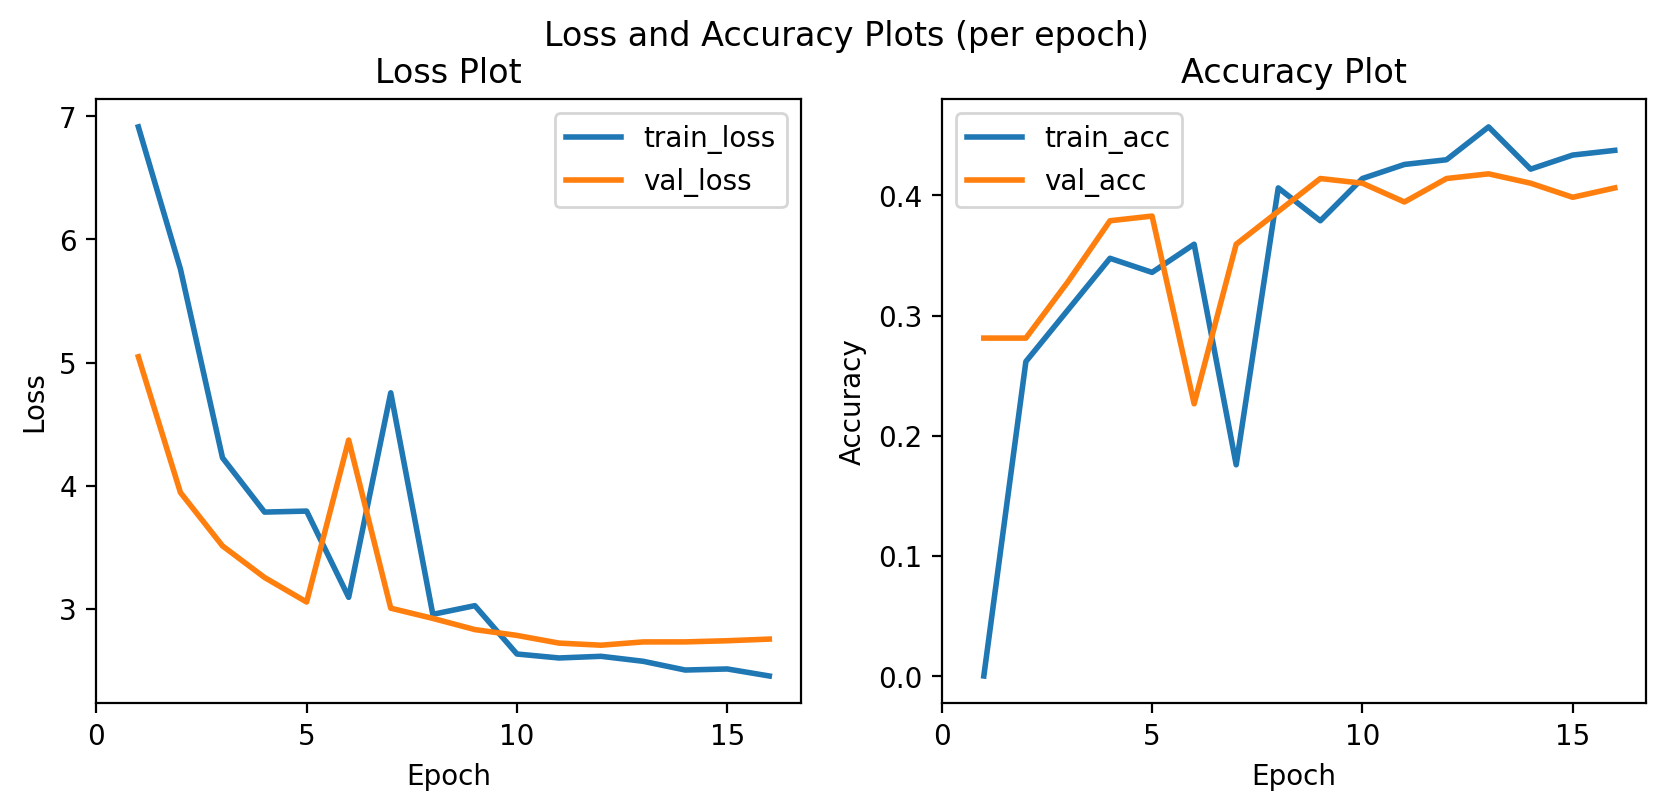

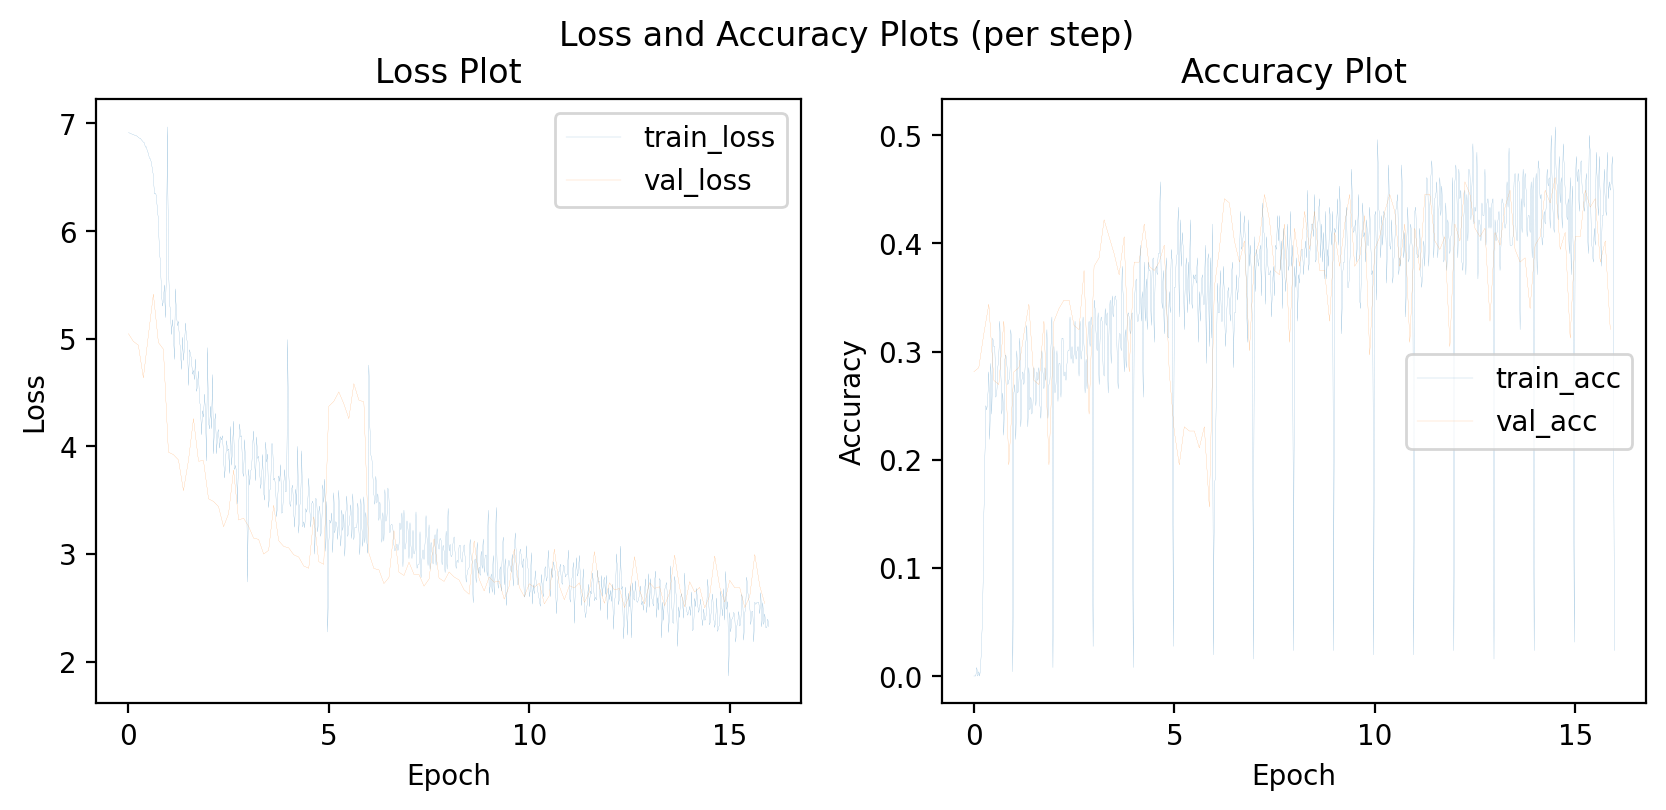

In [ ]:
with open('saved/plot_data_11.pkl','rb') as f:
    n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs = pickle.load(f) 

draw_plots( n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs,
           per_step = False)

draw_plots( n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs,
           per_step = True)

In [ ]:
#@title GradCam


## Code from https://github.com/jacobgil/pytorch-grad-cam
import torch
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models, transforms

class FeatureExtractor():
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)

        return target_activations, x

def preprocess_image(img):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    preprocessing = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    return preprocessing(img.copy()).unsqueeze(0)

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        features, output = self.extractor(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()
        
        one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_img.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


class GuidedBackpropReLU(Function):
    @staticmethod
    def forward(self, input_img):
        positive_mask = (input_img > 0).type_as(input_img)
        output = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), input_img, positive_mask)
        self.save_for_backward(input_img, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input_img, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input_img > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img),
                                   torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), grad_output,
                                                 positive_mask_1), positive_mask_2)
        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply

        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        input_img = input_img.requires_grad_(True)

        output = self.forward(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()

        one_hot = torch.sum(one_hot * output)
        one_hot.backward(retain_graph=True)

        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--use-cuda', action='store_true', default=False,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument('--image-path', type=str, default='./examples/both.png',
                        help='Input image path')
    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print("Using GPU for acceleration")
    else:
        print("Using CPU for computation")

    return args

def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)



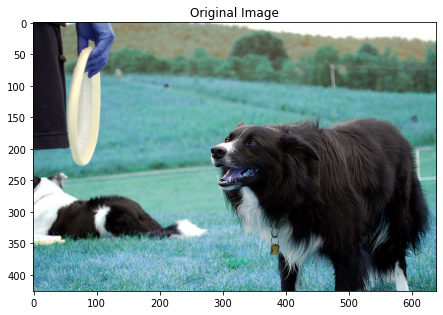

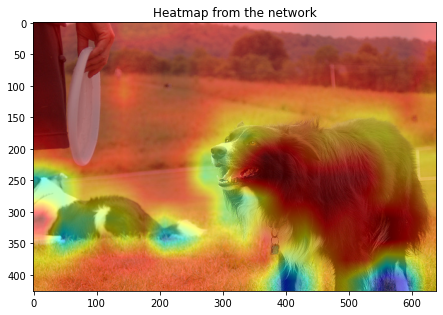

In [ ]:
#@title Heatmap
from torchvision import models
import matplotlib.pyplot as plt
import torch
dev=  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def visual(names, model, feature_module):
  grad_cam = GradCam(model=model, feature_module=feature_module, \
                      target_layer_names=[names], use_cuda=torch.cuda.is_available())
  model.eval()

  # k='./imagenette2'
  # k1=os.listdir(k)[1:]
  # k=k+'/'+k1[np.random.randint(len(k1))]
  # k1=os.listdir(k)
  # k=k+'/'+k1[np.random.randint(len(k1))]
  # k1=os.listdir(k)
  # k=k+'/'+k1[np.random.randint(len(k1))]

  k='train2014/COCO_train2014_000000524291.jpg'
  img = cv2.imread(k, 1)

  fig=plt.figure()
  ax1 = fig.add_axes((0.1,0.4,0.8,0.5))
  ax1.set_title("Original Image")
  ax1.imshow(img)
  fig.set_size_inches(7, 8, forward=True)
  plt.show()

  img_original=img.copy()
  #plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  img = np.float32(img) / 255
  # Opencv loads as BGR:
  img = img[:, :, ::-1]
  input_img = preprocess_image(img)

  target_category = None
  grayscale_cam = grad_cam(input_img, target_category)

  grayscale_cam = cv2.resize(grayscale_cam, (img.shape[1], img.shape[0]))
  cam = show_cam_on_image(img, grayscale_cam)

  tens=model.to(dev)(input_img.to(dev))
  out=torch.softmax(tens,dim=1)
  _, indices = torch.sort(out, descending=True)


  fig=plt.figure()
  ax1 = fig.add_axes((0.1,0.4,0.8,0.5))
  ax1.set_title("Heatmap from the network")
  ax1.imshow(cam)
  fig.set_size_inches(7, 8, forward=True)
  plt.show()

  #from termcolor import colored
  #print(colored('hello', 'red'), colored('world', 'green'))
  #print(colored("\nClassification Results: \n",'green'))


  #from prettytable import PrettyTable
  #t = PrettyTable(['Class', 'Confidence'])
  #out_l=[(dict_map[idx], 100*out[0][idx].item()) for idx in indices.cpu().numpy()[0][:5]]
  #for i in out_l:
  #    t.add_row([str(i[0]),i[1]])
  #print(t)

  #tabulate(out_l,headers=['Class', 'Confidence'])

model = models.vgg19_bn(pretrained = True)
visual("52", model, model.features)

  

#Model 2 : Attention 

In [ ]:
!pip install utils

In [ ]:
# %load extract_resnet_features.py

from utils import *

transform = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)])

class ImageDataset(Dataset):
    def __init__(self, json_list, split):
        self.imgids = list(set([i['image_id'] for i in json_list]))
        self.split = split


    def __len__(self):
        return len(self.imgids)

    def __getitem__(self, index):
        '''
        returns 2 tensors: image features tensor, imgid tensor.
        '''
        file = self.split+'2014/COCO_'+self.split+'2014_'+str(self.imgids[index]).rjust(12, '0')+'.jpg'
        if(imghdr.what(file) == 'jpeg'):
            item = {'image': transform(Image.fromarray(jpeg.JPEG(file).decode()))}
        else:
            item = {'image': transform(Image.open(file).convert('RGB'))}

        item['id'] = self.imgids[index]
        return item

def getResnetFeatures(batch_size, num_workers, split):


    w_resnet =  models.wide_resnet101_2(pretrained = True)

    # removing last layer4 sequential, last avgpool and linear layers to get 1024*14*14 features
    w_resnet = nn.Sequential(*list(w_resnet.children())[:-3])

    # storing modified resnet in resenet_mod
    resnet_mod = nn.Sequential(*list(w_resnet.children()))


    with open('train_val_lists.pkl', 'rb') as f:
        train_list, val_list = pickle.load(f)

    if(split == 'train'):
        list_json = train_list

    if(split == 'val'):
        list_json = val_list


    img_loader = DataLoader(
        ImageDataset(list_json, split),
        batch_size= batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=True,
        )

    del train_list
    del val_list
    del list_json

    resnet_mod.to('cuda')
    resnet_mod.eval()
    
    with h5py.File(img_loader.dataset.split+'_imgs_resnet.h5', libver='latest', mode = 'w') as f:
        img_features = f.create_dataset('img_features', shape=(len(img_loader.dataset), 1024, 14, 14), dtype='float16')
        img_ids = f.create_dataset('img_ids', shape=(len(img_loader.dataset),), dtype='int32')

        i = j = 0
        for data in tqdm(img_loader):
            imgs = data['image'].to('cuda')

            with torch.no_grad():
                out = resnet_mod(imgs)

            j = i + imgs.size(0)
            img_features[i:j, :, :] = out.cpu().numpy().astype('float16')
            img_ids[i:j] = data['id'].numpy().astype('int32')
            i = j


In [ ]:
getResnetFeatures(64, 3, "train")

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


  0%|          | 0.00/243M [00:00<?, ?B/s]

100%|██████████| 30/30 [00:53<00:00,  1.78s/it]


In [ ]:
getResnetFeatures(64, 3, "val")

100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


In [ ]:
class DeeperLSTM_QI_Att(nn.Module):
    def __init__(self, vocab_size, img_dim, dropout_p = 0.5):

        super(DeeperLSTM_QI_Att, self).__init__()

        # defining the layers
        self.embedding = nn.Embedding(vocab_size, 512, padding_idx = 0)
        self.fc_embed = nn.Linear(512, 512)
        self.lstm = nn.LSTM(512, 1024, num_layers =2, bidirectional = True, batch_first = True)
        self.fc_cell = nn.Linear(1024, 1024)

        self.attention = Attention(img_dim)
        self.fc1 = nn.Linear(2048+1024, 1024)
        self.fc2 = nn.Linear(1024, 1000)
        self.dropout = nn.Dropout(dropout_p)
        # initializing weights
        self.init_weights()


    def forward(self, img_input, text_input):

        # embedding layer: [batch_size, 25] to [batch_size, 25, 512]
        # with gelu non-linearity
        text_embedded = F.gelu(self.fc_embed(self.embedding(text_input)))

        # lstm layer (hidden, cell): [batch_size, 25, 512] to [2, batch_size, 1024]
        _, (_, lstm_cell)  = self.lstm(text_embedded)

        # lstm_cell[-1] gets cell state of 2nd layer
        # [batch_size, 1024] to [batch_size, 1024]
        question_feats = self.dropout(F.gelu(self.fc_cell(lstm_cell[-1])))

        # L2-normalized img feats
        img_feats = F.normalize(img_input, dim = 1, p=2)

        weighted_img_attention = self.attention(img_feats, question_feats)

        # [batch_size, 2048+1024]
        combined = torch.cat([weighted_img_attention, question_feats], dim = 1)

        # [batch_size, 2048] to [batch_size, 1024]
        fc_1 = self.dropout(F.gelu(self.fc1(combined)))

        # output: [batch_size, 1000]
        output = F.softmax(self.fc2(fc_1), dim=1)

        return output

    def init_weights(self):

        # kaiming_uniform is same as he_uniform initialization
        init = torch.nn.init.kaiming_uniform_
        for layer in self.lstm.all_weights:
            for hidden in layer[:2]:
                init(hidden)

        init(self.fc_embed.weight)
        init(self.attention.img_conv.weight)
        init(self.attention.glimpse_conv.weight)
        init(self.fc_cell.weight)
        init(self.fc1.weight)
        init(self.fc2.weight)

class Attention(nn.Module):
    def __init__(self, img_dim = 1024, glimpses = 2):
        super(Attention, self).__init__()

        self.glimpses  = glimpses
        self.img_conv = nn.Conv2d(img_dim, 1024, 1)
        self.glimpse_conv = nn.Conv2d(1024, glimpses, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, i_feats, q_feats):

        # [batch_size, 1024, 14, 14] to [batch_size, 1024, 14, 14] since 1x1 filters.
        i = F.gelu(self.img_conv(i_feats))
        
        # Repeating q_feats in all spatial positions of i conv features
        # [batch_size, 1024] to [batch_size, 1024, 14, 14]
        q = q_feats.view(q_feats.size()[0], q_feats.size()[1], 1, 1).expand_as(i)
        
        # adding both i and q features
        combined = F.gelu(i + q)
        
        # getting attention features by passing combined into 2 glimpse conv2d
        # [batch_size, 1024, 14, 14] to [batch_size, 2, 14, 14]
        glimpse_conv = self.dropout(F.gelu(self.glimpse_conv(combined)))
        
        # [batch_size, 2, 14, 14] to [batch_size, 2, 14*14]
        glimpse_conv = glimpse_conv.view(i_feats.size()[0], self.glimpses, -1)
        
        # softmax across 2 (14*14) features
        # [batch_size, 2, 14*14] to [batch_size, 2, 1, 14*14]
        attention = F.softmax(glimpse_conv, dim=-1).unsqueeze(2)

        # [batch_size, 1024, 14, 14] to [batch_size, 1, 1024, 14*14] : unsqueeze 2nd dim and flatten 3rd dim
        i_feats = i_feats.view(i_feats.size()[0], 1, i_feats.size()[1], -1)
        
        # [batch_size, 1, 1024, 14*14] i.e., multiplying 1024 (14*14) i_feats with 14*14 attention for 2 glimpses.
        weighted = attention * i_feats

        # [batch_size, 2, 1024, 14*14] to [batch_size, 2048]
        weighted_mean = weighted.sum(dim=-1).view(i_feats.size()[0], -1)

        return weighted_mean


In [ ]:
class VQADataset_I(Dataset):
    def __init__(self, json_list, question_vocab, answer_vocab, split = None):
        self.text_data = json_list
        self.split = split

        self.questions_encoded = encode_questions(self.text_data, question_vocab)
        self.answers_encoded, self.multi_answers = encode_answers(self.text_data, answer_vocab)

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, index):

        # h5 objects cant be pickled when declared in __init__
        if not hasattr(self, 'img_h5'):
            self.img_h5 = h5py.File(self.split+'_imgs_resnet.h5', libver='latest', mode = 'r')
            self.img_features = self.img_h5['img_features']
            img_ids_list = list(self.img_h5['img_ids'])
            self.img_ids = {}
            for i in range(len(img_ids_list)):
                self.img_ids[img_ids_list[i]] = i

        '''
        returns 4 tensors: image tensor, encoded question tensor, encoded answer tensor, multi answer tensor.
        '''
        item = {}
        item['image'] = torch.tensor(self.img_features[self.img_ids[self.text_data[index]['image_id']]], dtype = torch.float32)
        item['question'] = torch.tensor(self.questions_encoded[index])
        item['answer'] = torch.tensor(self.answers_encoded[index], dtype = torch.long)
        item['multi_answer'] = torch.tensor(self.multi_answers[index], dtype = torch.long)
        return item

def train_att(num_workers, batch_size):

    with open('vocab.pkl', 'rb') as f:
        question_vocab, answer_vocab = pickle.load(f)

    with open('train_val_lists.pkl', 'rb') as f:
        train_list, val_list = pickle.load(f)

    train_dataset = VQADataset_I(train_list,
                                 question_vocab,
                                 answer_vocab,
                                split = 'train')
    val_dataset = VQADataset_I(val_list,
                                question_vocab,
                                answer_vocab,
                                split = 'val')

    del train_list
    del val_list

    train_dataloader = DataLoader(train_dataset,
                                batch_size=batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

    val_dataloader = DataLoader(val_dataset,
                                batch_size=batch_size, shuffle = False, num_workers = num_workers, pin_memory = True)



    device = torch.device('cuda:0')
    epochs = 20

    model = DeeperLSTM_QI_Att(len(question_vocab),1024, dropout_p = 0.5)
    optimizer = torch.optim.Adamax(model.parameters(), lr =0.001)

    onecycle_scheduler = lr_scheduler.OneCycleLR(optimizer, steps_per_epoch = train_dataloader.__len__(), max_lr = 0.005, epochs = epochs)
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    cumm_val_losses = []

    unk_answer_idx = answer_vocab['<UNK>'] # to ignore unknown answer index
    criterion = torch.nn.NLLLoss(ignore_index = unk_answer_idx).to(device)

    model.to(device)

    n_batches_train = train_dataloader.__len__()
    n_batches_val = val_dataloader.__len__()
    train_len = train_dataloader.dataset.__len__()
    val_len = val_dataloader.dataset.__len__()

    min_loss = 99
    
    writer = SummaryWriter('runs/model2')

    for epoch in range(epochs):

        start = dt.now()
        train_loss = 0
        train_correct = 0
        model = model.train()

        for batch, data in enumerate(train_dataloader):

            # unzipping data and loading it to GPU
            data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
            multi_ans = data['multi_answer']
            answers = data['answer']

            # zeroing the previous optimizer calculations
            optimizer.zero_grad()

            output = model(data['image'], data['question'])

            # modifying answers tensor by replacing wrong output answers with possible multi answers.
            predictions = torch.argmax(output.cpu(), 1)
            indices = torch.where(~(answers == predictions))[0]
            for idx in indices:
                if predictions[idx] in multi_ans[idx]:
                    answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

            loss = criterion(torch.log(output+0.000001),  answers.cuda())

            # backpropagating loss
            loss.backward()

            optimizer.step()
            onecycle_scheduler.step()

            predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
            n_corrects = (predictions == answers).sum().item()
        
            train_accs.append(n_corrects/batch_size)
            train_losses.append(loss.item()) 

            if(batch%100 == 99):
                writer.add_scalar('training loss',
                                    train_losses[-1],
                                    epoch * n_batches_train + batch)

                writer.add_scalar('training accuracy',
                                    train_accs[-1],
                                    epoch * n_batches_train + batch)

            train_correct += (predictions == answers).sum().item()
            train_loss += loss.item()

            printout = '\r Epoch: {}  Batches: {}/{} loss: {:.5f} acc: {:.4f}'.format(epoch+1, batch+1, n_batches_train, train_loss/(batch+1), train_correct/(min((batch+1)*batch_size, train_len)))
            print(printout, end= '')
            
        val_correct = 0
        val_loss = 0
        with torch.no_grad():
            model = model.eval()
            for batch, data in enumerate(val_dataloader):

                data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
                multi_ans = data['multi_answer']
                answers = data['answer']

                output = model(data['image'], data['question'])

                # modifying answers tensor by replacing wrong output answers with possible multi answers.
                predictions = torch.argmax(output.cpu(), 1)
                indices = torch.where(~(answers == predictions))[0]
                for idx in indices:
                    if predictions[idx] in multi_ans[idx]:
                        answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

                vloss = criterion(torch.log(output+0.000001),  answers.cuda())

                predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
                n_corrects_val = (predictions == answers).sum().item()

                val_accs.append(n_corrects_val/batch_size)
                val_losses.append(vloss.item())   

                val_correct += n_corrects_val
                val_loss += vloss.item()
                
                print(printout+' val_batches : {}/{} val_loss: {:.5f} val_acc: {:.4f}'.format(batch+1, n_batches_val, val_loss/(batch+1), val_correct/(min((batch+1)*batch_size, val_len))), end = '')
            print(' [{}]'.format(dt.now()-start))
            cumm_val_losses.append(val_loss/(batch+1))
            
        torch.save(model.state_dict(), 'saved/model_att1_state_dict')

         # saving accuracies and losses for plotting later.
        with open('saved/plot_data_att1.pkl','wb') as f:
            pickle.dump([n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs], f)

        # Earlystopping with patience 5.
        if(cumm_val_losses[-1] < min_loss):
            # saving best model to disk
            torch.save(model.state_dict(), 'saved/model_att1_es_state_dict')
            min_loss = cumm_val_losses[-1]
            patience = 0
        else:
            patience += 1
        if(patience == 2):
            print('\n EarlyStopped.')
            break

In [ ]:
train_att(3, 256)

 Epoch: 1  Batches: 40/40 loss: 4.41866 acc: 0.3067 val_batches : 8/8 val_loss: 3.32302 val_acc: 0.3665 [0:01:20.790656]
 Epoch: 2  Batches: 40/40 loss: 3.61337 acc: 0.3393 val_batches : 8/8 val_loss: 3.07356 val_acc: 0.3855 [0:01:18.143731]
 Epoch: 3  Batches: 40/40 loss: 3.37708 acc: 0.3556 val_batches : 8/8 val_loss: 2.93157 val_acc: 0.3760 [0:01:16.921804]
 Epoch: 4  Batches: 40/40 loss: 3.23165 acc: 0.3740 val_batches : 8/8 val_loss: 2.83505 val_acc: 0.3835 [0:01:17.298837]
 Epoch: 5  Batches: 40/40 loss: 3.05215 acc: 0.3786 val_batches : 8/8 val_loss: 2.75371 val_acc: 0.3970 [0:01:17.651216]
 Epoch: 6  Batches: 40/40 loss: 2.84747 acc: 0.3988 val_batches : 8/8 val_loss: 2.69259 val_acc: 0.4125 [0:01:17.235983]
 Epoch: 7  Batches: 40/40 loss: 2.61462 acc: 0.4410 val_batches : 8/8 val_loss: 2.60415 val_acc: 0.4195 [0:01:18.712285]
 Epoch: 8  Batches: 40/40 loss: 2.30083 acc: 0.4857 val_batches : 8/8 val_loss: 2.57209 val_acc: 0.4270 [0:01:17.004381]
 Epoch: 9  Batches: 40/40 loss: 

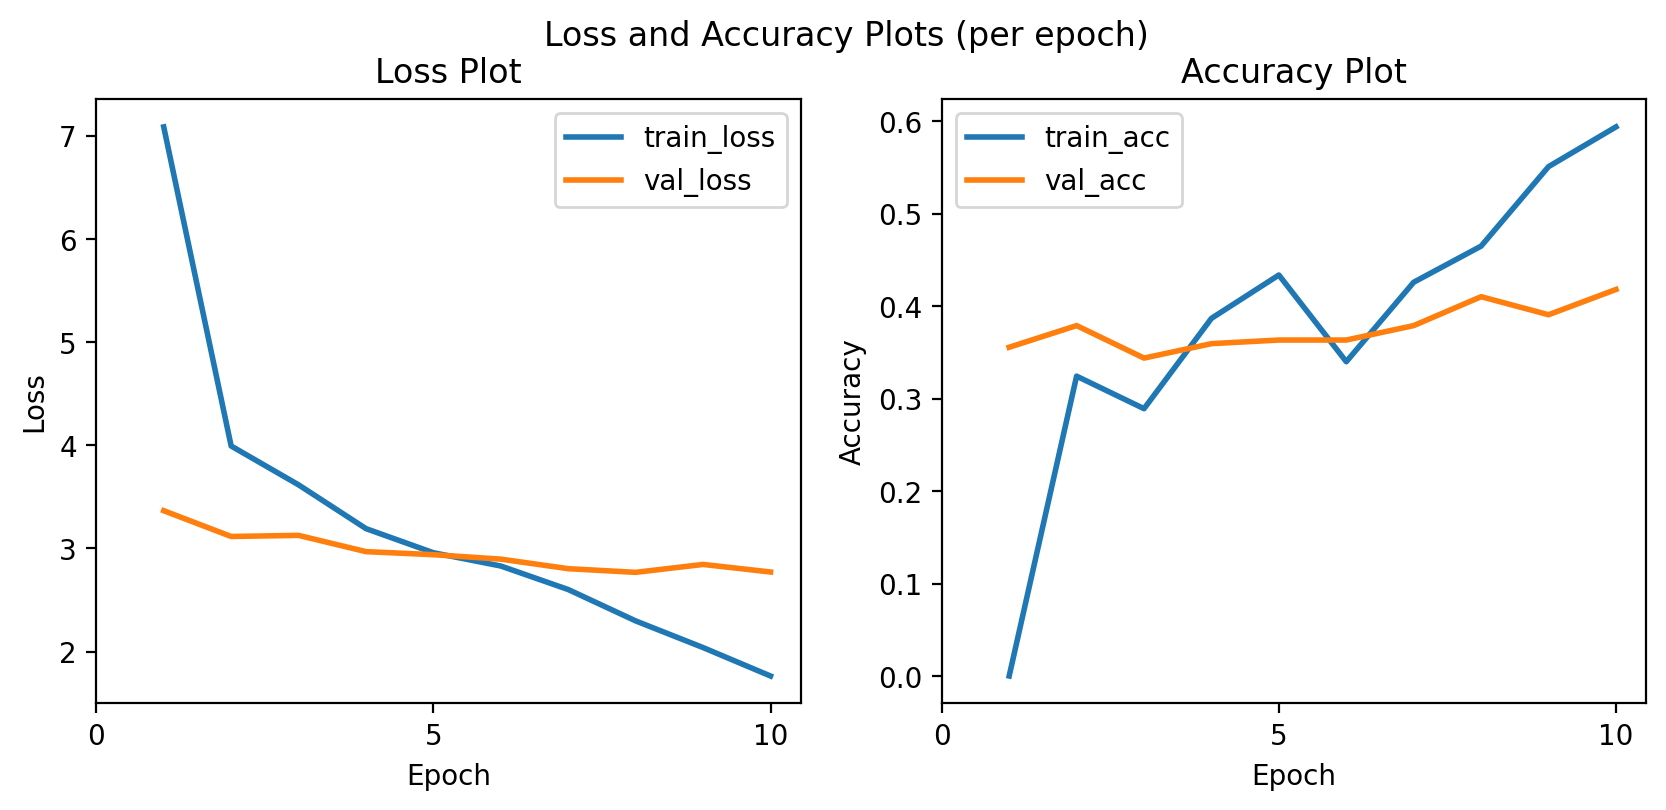

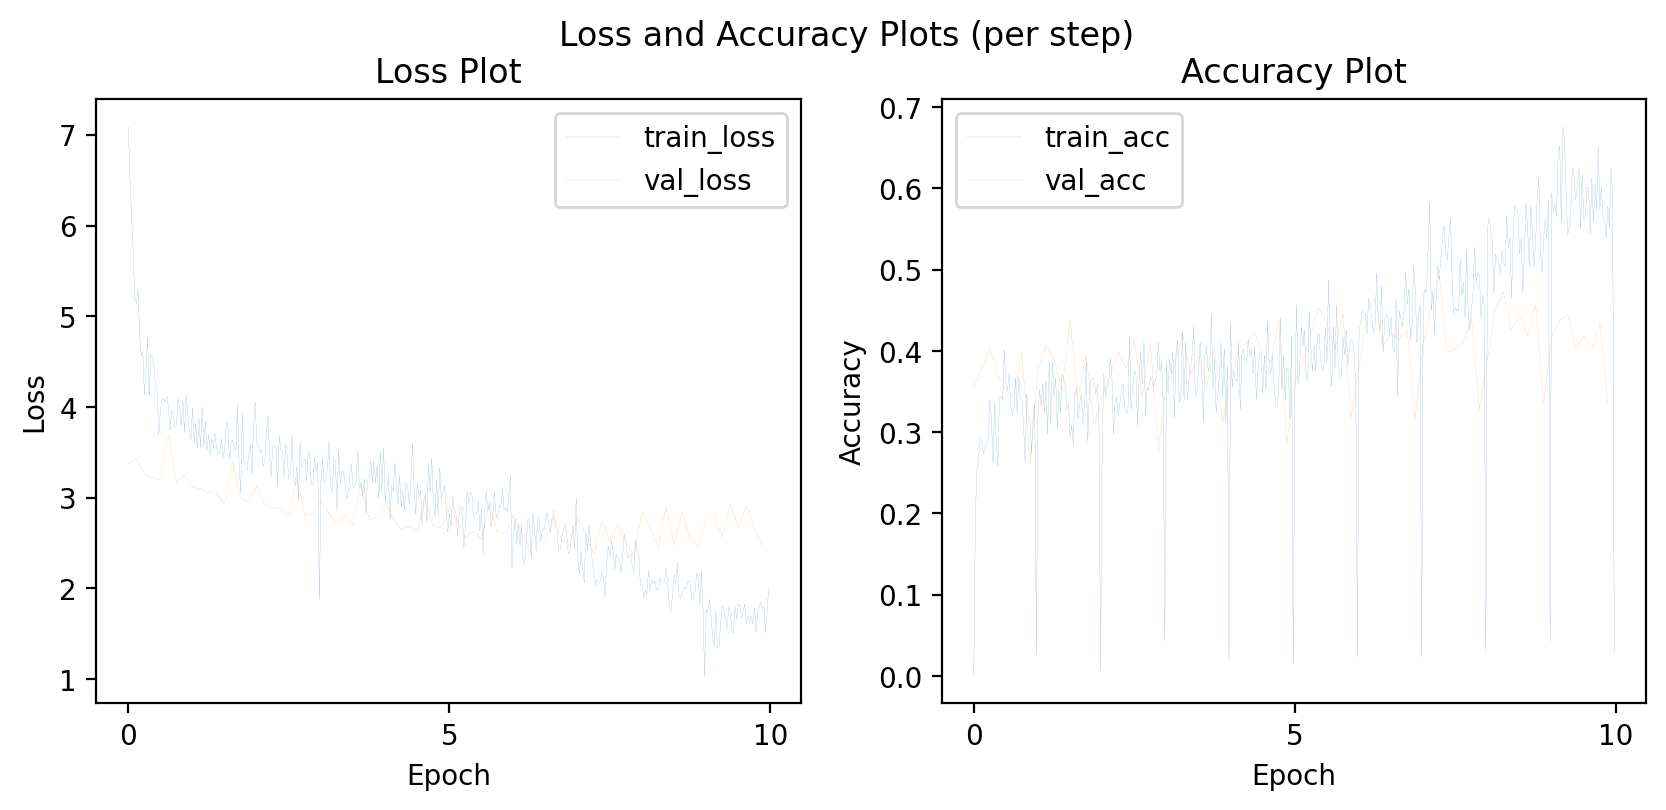

In [ ]:
with open('saved/plot_data_att1.pkl','rb') as f:
    n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs = pickle.load(f) 

draw_plots(n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs,
    per_step = False)

draw_plots(n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs,
    per_step = True)

#Model 3: Co-Attention

In [ ]:
# %load extract_resnet_features_512.py

from utils import *

transform = transforms.Compose([
transforms.Resize((448,448)),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)])

class ImageDataset(Dataset):
    def __init__(self, json_list, split):
        self.imgids = list(set([i['image_id'] for i in json_list]))
        self.split = split


    def __len__(self):
        return len(self.imgids)

    def __getitem__(self, index):
        '''
        returns 2 tensors: image features tensor, imgid tensor.
        '''
        file = self.split+'2014/COCO_'+self.split+'2014_'+str(self.imgids[index]).rjust(12, '0')+'.jpg'
        if(imghdr.what(file) == 'jpeg'):
            item = {'image': transform(Image.fromarray(jpeg.JPEG(file).decode()))}
        else:
            item = {'image': transform(Image.open(file).convert('RGB'))}

        item['id'] = self.imgids[index]
        return item

def getResnet152Features(num_workers, batch_size, split):

    
    resnet =  models.resnet152(pretrained = True)
    
    # modifing layer 4 to output 512X14X14 dim vector
    resnet.layer4[-1] = nn.Sequential(*list(resnet.layer4[-1].children())[:2])

    # removing last avg_pool and dense layer
    resnet = nn.Sequential(*list(resnet.children())[:-2])


    with open('train_val_lists.pkl', 'rb') as f:
        train_list, val_list = pickle.load(f)

    if(split == 'train'):
        list_json = train_list

    if(split == 'val'):
        list_json = val_list


    img_loader = DataLoader(
        ImageDataset(list_json, split),
        batch_size= batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=True,
        )

    del train_list
    del val_list
    del list_json

    resnet.to('cuda')
    resnet.eval()
    
    with h5py.File(img_loader.dataset.split+'_imgs_resnet_512.h5', libver='latest', mode = 'w') as f:
        img_features = f.create_dataset('img_features', shape=(len(img_loader.dataset), 512, 14, 14), dtype='float16')
        img_ids = f.create_dataset('img_ids', shape=(len(img_loader.dataset),), dtype='int32')

        i = j = 0
        for data in tqdm(img_loader):
            imgs = data['image'].to('cuda')

            with torch.no_grad():
                out = resnet(imgs)

            j = i + imgs.size(0)
            img_features[i:j, :, :] = out.cpu().numpy().astype('float16')
            img_ids[i:j] = data['id'].numpy().astype('int32')
            i = j


In [ ]:
getResnet152Features(3, 64, "train")

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

100%|██████████| 30/30 [02:40<00:00,  5.34s/it]


In [ ]:
getResnet152Features(3, 64, "val")

100%|██████████| 6/6 [00:30<00:00,  5.15s/it]


In [ ]:
class Hierarchical_CoAtt(nn.Module):

    def __init__(self, vocab_size, embed_dim = 512, q_len = 25):
        super().__init__()

        self.dropout = nn.Dropout(0.5)
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx = 0)
        self.fc_embed = nn.Linear(embed_dim, embed_dim)

        # appropriately zero padded the inputs of conv to have same dimensions after operations.
        self.unigram_conv = nn.Conv1d(embed_dim, embed_dim, 1, padding=0)
        self.bigram_conv  = nn.Conv1d(embed_dim, embed_dim, 2, padding=0)
        self.trigram_conv = nn.Conv1d(embed_dim, embed_dim, 3, padding=1)

        # to maxpool the outputs of unigrams, bigrams and trigrams
        self.maxpool = nn.MaxPool2d((3, 1))
        self.lstm = nn.LSTM(embed_dim, embed_dim, num_layers=3, batch_first = True)

        # Below are weight matrices used in the papers
        self.W_b = nn.Parameter(torch.randn(embed_dim, embed_dim))
        self.W_v = nn.Parameter(torch.randn(q_len, embed_dim))
        self.W_q = nn.Parameter(torch.randn(q_len, embed_dim))
        self.w_hv = nn.Parameter(torch.randn(q_len, 1))
        self.w_hq = nn.Parameter(torch.randn(q_len, 1))

        self.W_w = nn.Linear(embed_dim, embed_dim) # Dense layer for image, word parallel co-attention
        self.W_p = nn.Linear(embed_dim*2, embed_dim) # Dense layer for image, phrase parallel co-attention
        self.W_s = nn.Linear(embed_dim*2, 1024) # Dense layer for image, sentence parallel co-attention

        self.fc = nn.Linear(1024, 1000)

        self.init_weights()

    def forward(self, image, question):

        # [batch_size, 512, 14, 14] to [batch_size, 512, 14x14]
        image = image.view(image.size(0), image.size(1), -1)

        # [batch_size, 25, 512]
        words = torch.tanh(self.fc_embed(self.embed(question)))
        words = words.permute(0, 2, 1)   # [batch_size, 512, 25], transposed to do conv operation

        # [batch_size, 512, 25] to [batch_size, 512, 1, 25]
        unigrams = torch.unsqueeze(torch.tanh(self.unigram_conv(words)), 2)

        # [batch_size, 512, 25] to [batch_size, 512, 1, 25]
        bigram_padded_input = F.pad(words, (0,1), mode='constant', value = 0) # since the length is even, pad at one side only.
        bigrams  = torch.unsqueeze(torch.tanh(self.bigram_conv(bigram_padded_input)), 2)

        # [batch_size, 512, 25] to [batch_size, 512, 1, 25]
        trigrams = torch.unsqueeze(torch.tanh(self.trigram_conv(words)),2)

        words = words.permute(0, 2, 1)

        # [batch_size, 512, 3,  25] to [batch_size, 512, 25]
        phrase = torch.squeeze(self.maxpool(torch.cat((unigrams, bigrams, trigrams), 2)), 2)
        phrase = phrase.permute(0, 2, 1)

        # [batch_size, 512, 25] to [batch_size, 512, 25]
        sentence, _ = self.lstm(phrase)

        # Applying Hierarchical CoAttention
        v_word, q_word = self.parallel_co_attention(image, words)
        v_phrase, q_phrase = self.parallel_co_attention(image, phrase)
        v_sent, q_sent = self.parallel_co_attention(image, sentence)

        # [batch_size, 512]
        h_w = torch.tanh(self.W_w(q_word + v_word))

        # [batch_size, 512]
        h_p = torch.tanh(self.W_p(torch.cat(((q_phrase + v_phrase), h_w), dim=1)))

        # [batch_size, 512] to [batch_size, 1024]
        h_s = self.dropout(torch.tanh(self.W_s(torch.cat(((q_sent + v_sent), h_p), dim=1))))

        # [batch_size, 1024] to [batch_size, 1000]
        output = F.softmax(self.fc(h_s), dim = 1)

        return output

    def parallel_co_attention(self, V, Q):
        # [batch_size, 25, 512] X ([batch_size, 512] X [batch_size, 512, 196]) = [batch_size, 25, 196]
        C = torch.matmul(Q, torch.matmul(self.W_b, V))

        # ([batch_size, 25, 512] X [batch_size, 512, 196]) + (([batch_size, 25, 512] X [batch_size, 512, 25]) X [batch_size, 25, 196])
        # = [batch_size, 25, 196]
        H_v = torch.tanh(torch.matmul(self.W_v, V) + torch.matmul(torch.matmul(self.W_q, Q.permute(0, 2, 1)), C))

        # ([batch_size, 25, 512] X [batch_size, 512, 25]) + (([batch_size, 25, 512] X [batch_size, 512, 196]) X [batch_size, 196, 25])
        # = [batch_size, 25, 25]
        H_q = torch.tanh(torch.matmul(self.W_q, Q.permute(0, 2, 1)) + torch.matmul(torch.matmul(self.W_v, V), C.permute(0, 2, 1)))

        # ([batch_size, 1, 25] X [batch_size, 25, 196]) to [batch_size, 1, 196]
        a_v = F.softmax(torch.matmul(torch.t(self.w_hv), H_v), dim=2)

        # ([batch_size, 1, 25] X [batch_size, 25, 25]) to [batch_size, 1, 25]
        a_q = F.softmax(torch.matmul(torch.t(self.w_hq), H_q), dim=2)

        # [batch_size, 1, 196] X [batch_size, 196, 512] to [batch_size, 512]
        v = torch.squeeze(torch.matmul(a_v, V.permute(0, 2, 1)), 1)

        # [batch_size, 1, 25] X [batch_size, 25, 512] to [batch_size, 512]
        q = torch.squeeze(torch.matmul(a_q, Q), 1)

        return v, q

    def init_weights(self):
        # kaiming_uniform is same as he_uniform initialization
        init = torch.nn.init.kaiming_uniform_
        for layer in self.lstm.all_weights:
            for hidden in layer[:2]:
                init(hidden)

        init(self.fc_embed.weight)

        init(self.unigram_conv.weight)
        init(self.bigram_conv.weight)
        init(self.trigram_conv.weight)

        init(self.W_w.weight)
        init(self.W_p.weight)
        init(self.W_s.weight)
        init(self.fc.weight)


In [ ]:
class VQADataset_IH(Dataset):
    def __init__(self, json_list, question_vocab, answer_vocab, split = None):
        self.text_data = json_list
        self.split = split

        self.questions_encoded = encode_questions(self.text_data, question_vocab)
        self.answers_encoded, self.multi_answers = encode_answers(self.text_data, answer_vocab)

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, index):

        # h5 objects cant be pickled when declared in __init__
        if not hasattr(self, 'img_h5'):
            self.img_h5 = h5py.File(self.split+'_imgs_resnet_512.h5', libver='latest', mode = 'r')
            self.img_features = self.img_h5['img_features']
            img_ids_list = list(self.img_h5['img_ids'])
            self.img_ids = {}
            for i in range(len(img_ids_list)):
                self.img_ids[img_ids_list[i]] = i

        '''
        returns 4 tensors: image tensor, encoded question tensor, encoded answer tensor, multi answer tensor.
        '''
        item = {}
        item['image'] = torch.tensor(self.img_features[self.img_ids[self.text_data[index]['image_id']]], dtype = torch.float32)
        item['question'] = torch.tensor(self.questions_encoded[index])
        item['answer'] = torch.tensor(self.answers_encoded[index], dtype = torch.long)
        item['multi_answer'] = torch.tensor(self.multi_answers[index], dtype = torch.long)
        return item


def train_coatt(num_workers, batch_size):

    with open('vocab.pkl', 'rb') as f:
        question_vocab, answer_vocab = pickle.load(f)

    with open('train_val_lists.pkl', 'rb') as f:
        train_list, val_list = pickle.load(f)

    train_dataset = VQADataset_IH(train_list,
                                 question_vocab,
                                 answer_vocab,
                                split = 'train')
    val_dataset = VQADataset_IH(val_list,
                                question_vocab,
                                answer_vocab,
                                split = 'val')

    del train_list
    del val_list

    train_dataloader = DataLoader(train_dataset,
                                batch_size=batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

    val_dataloader = DataLoader(val_dataset,
                                batch_size=batch_size, shuffle = False, num_workers = num_workers, pin_memory = True)



    device = torch.device('cuda:0')
    epochs = 50

    model = Hierarchical_CoAtt(len(question_vocab),512, 25)
    optimizer = torch.optim.Adamax(model.parameters(), lr =0.0003)

    onecycle_scheduler = lr_scheduler.OneCycleLR(optimizer, steps_per_epoch = train_dataloader.__len__(), max_lr = 0.0012, epochs = epochs)
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    cumm_val_losses = []

    unk_answer_idx = answer_vocab['<UNK>'] # to ignore unknown answer index
    criterion = torch.nn.NLLLoss(ignore_index = unk_answer_idx).to(device)

    model.to(device)

    n_batches_train = train_dataloader.__len__()
    n_batches_val = val_dataloader.__len__()
    train_len = train_dataloader.dataset.__len__()
    val_len = val_dataloader.dataset.__len__()

    min_loss = 99
    
    writer = SummaryWriter('runs/model3')


    for epoch in range(epochs):

        start = dt.now()
        train_loss = 0
        train_correct = 0
        model = model.train()

        for batch, data in enumerate(train_dataloader):

            # unzipping data and loading it to GPU
            data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
            multi_ans = data['multi_answer']
            answers = data['answer']

            # zeroing the previous optimizer calculations
            optimizer.zero_grad()

            output = model(data['image'], data['question'])

            # modifying answers tensor by replacing wrong output answers with possible multi answers.
            predictions = torch.argmax(output.cpu(), 1)
            indices = torch.where(~(answers == predictions))[0]
            for idx in indices:
                if predictions[idx] in multi_ans[idx]:
                    answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

            loss = criterion(torch.log(output+1e-6),  answers.cuda())

            # backpropagating loss
            loss.backward()

            optimizer.step()
            onecycle_scheduler.step()

            predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
            n_corrects = (predictions == answers).sum().item()
        
            train_accs.append(n_corrects/batch_size)
            train_losses.append(loss.item()) 

            if(batch%100 == 99):
                writer.add_scalar('training loss',
                                    train_losses[-1],
                                    epoch * n_batches_train + batch)

                writer.add_scalar('training accuracy',
                                    train_accs[-1],
                                    epoch * n_batches_train + batch)


            train_correct += n_corrects
            train_loss += loss.item()

            printout = '\r Epoch: {}  Batches: {}/{} loss: {:.5f} acc: {:.4f}'.format(epoch+1, batch+1, n_batches_train, train_loss/(batch+1), train_correct/(min((batch+1)*batch_size, train_len)))
            print(printout, end= '')
            
        val_correct = 0
        val_loss = 0
        with torch.no_grad():
            model = model.eval()
            for batch, data in enumerate(val_dataloader):

                data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
                multi_ans = data['multi_answer']
                answers = data['answer']

                output = model(data['image'], data['question'])

                # modifying answers tensor by replacing wrong output answers with possible multi answers.
                predictions = torch.argmax(output.cpu(), 1)
                indices = torch.where(~(answers == predictions))[0]
                for idx in indices:
                    if predictions[idx] in multi_ans[idx]:
                        answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

                vloss = criterion(torch.log(output+0.000001),  answers.cuda())

                predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
                n_corrects_val = (predictions == answers).sum().item()

                val_accs.append(n_corrects_val/batch_size)
                val_losses.append(vloss.item())   

                val_correct += n_corrects_val
                val_loss += vloss.item()
                print(printout+' val_batches : {}/{} val_loss: {:.5f} val_acc: {:.4f}'.format(batch+1, n_batches_val, val_loss/(batch+1), val_correct/(min((batch+1)*batch_size, val_len))), end = '')
            print(' [{}]'.format(dt.now()-start))
            cumm_val_losses.append(val_loss/(batch+1))
            
        torch.save(model.state_dict(), 'saved/model_coatt1_state_dict')

         # saving accuracies and losses for plotting later.
        with open('saved/plot_data_coatt1.pkl','wb') as f:
            pickle.dump([n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs], f)

        # Earlystopping with patience 5.
        if(cumm_val_losses[-1] < min_loss):
            # saving best model to disk
            torch.save(model.state_dict(), 'saved/model_coatt1_es_state_dict')
            min_loss = cumm_val_losses[-1]
            patience = 0
        else:
            patience += 1
        if(patience == 3):
            print('\n EarlyStopped.')
            break


In [ ]:
train_coatt(3, 256)

 Epoch: 1  Batches: 40/40 loss: 5.79206 acc: 0.2068 val_batches : 8/8 val_loss: 4.79697 val_acc: 0.2875 [0:00:37.169443]
 Epoch: 2  Batches: 40/40 loss: 5.02642 acc: 0.2771 val_batches : 8/8 val_loss: 4.41944 val_acc: 0.2965 [0:00:36.023534]
 Epoch: 3  Batches: 40/40 loss: 4.71075 acc: 0.2827 val_batches : 8/8 val_loss: 4.19788 val_acc: 0.3005 [0:00:36.431993]
 Epoch: 4  Batches: 40/40 loss: 4.53715 acc: 0.2893 val_batches : 8/8 val_loss: 4.05205 val_acc: 0.3080 [0:00:35.861282]
 Epoch: 5  Batches: 40/40 loss: 4.35002 acc: 0.2936 val_batches : 8/8 val_loss: 3.93015 val_acc: 0.3205 [0:00:36.413621]
 Epoch: 6  Batches: 40/40 loss: 4.19912 acc: 0.3097 val_batches : 8/8 val_loss: 3.82575 val_acc: 0.3200 [0:00:36.067897]
 Epoch: 7  Batches: 40/40 loss: 4.05101 acc: 0.3190 val_batches : 8/8 val_loss: 3.71130 val_acc: 0.3265 [0:00:36.017145]
 Epoch: 8  Batches: 40/40 loss: 3.94609 acc: 0.3276 val_batches : 8/8 val_loss: 3.63402 val_acc: 0.3405 [0:00:35.766211]
 Epoch: 9  Batches: 40/40 loss: 

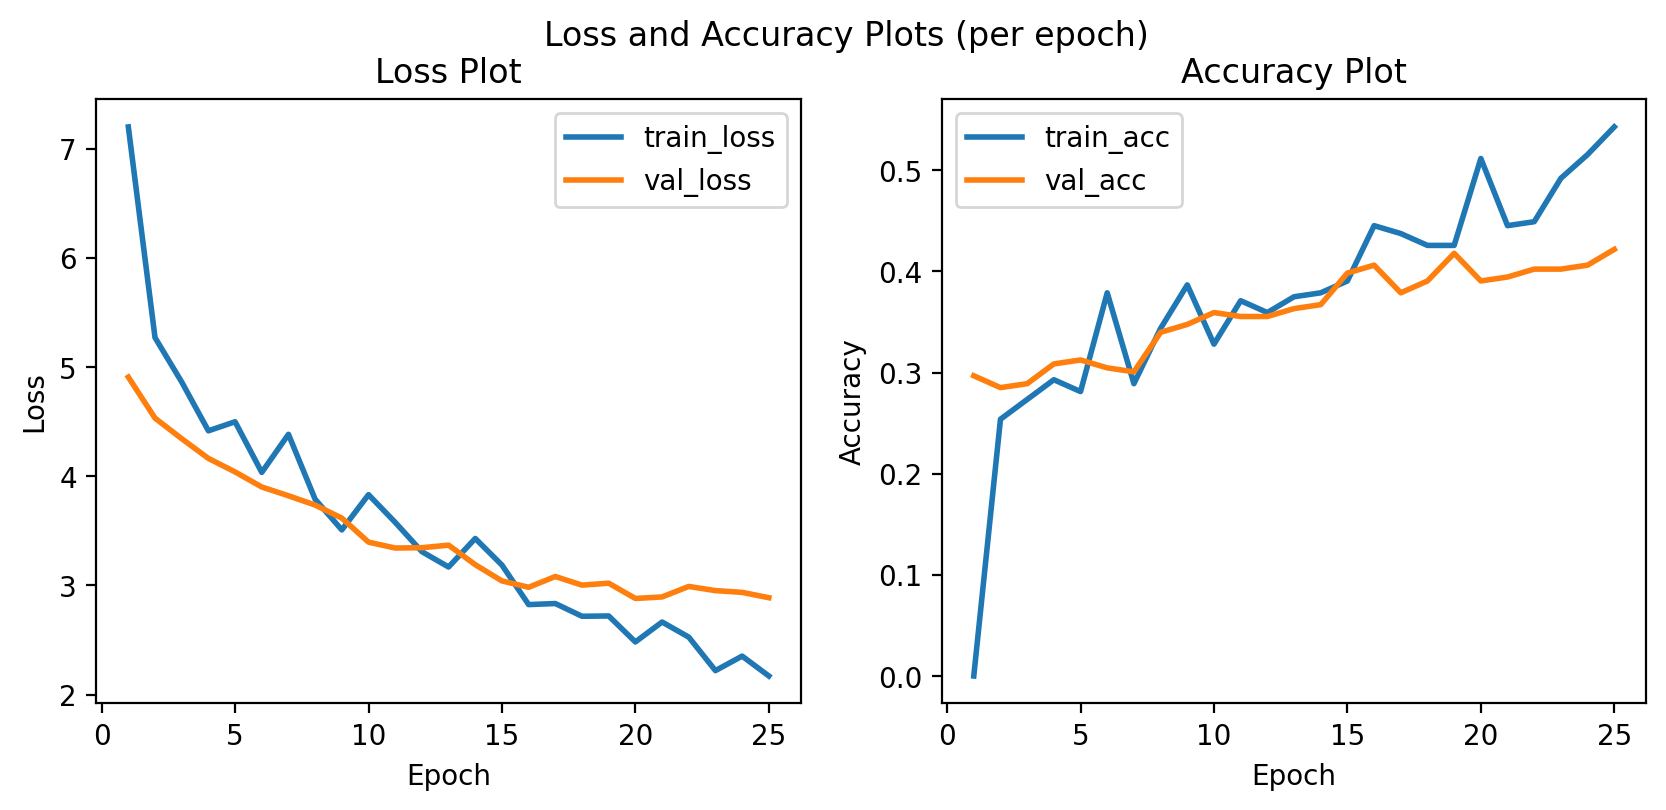

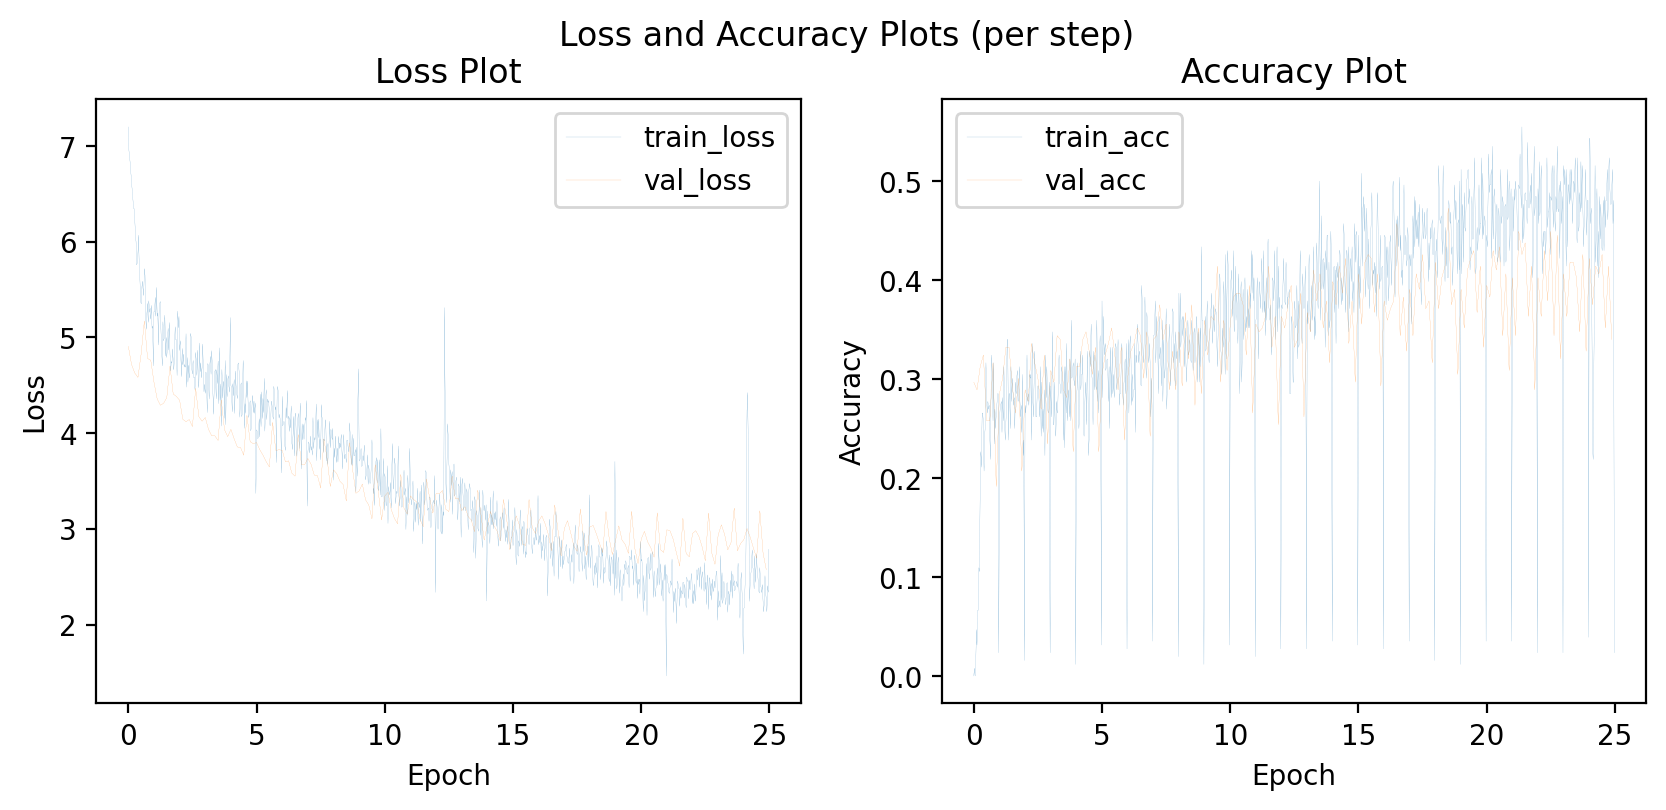

In [ ]:
with open('saved/plot_data_coatt1.pkl','rb') as f:
    n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs = pickle.load(f) 

draw_plots(n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs,
    per_step = False)

draw_plots(n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs,
    per_step = True)

#LSTM + CNN with Backpropping through CNN, using a Pretrained VGG CNN

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import models
class VQAImageDataset(Dataset):
    def __init__(self, json_list, question_vocab, answer_vocab, split, answer_type = None):
        self.text_data = json_list
        self.split = split
        self.imgids = list(set([i['image_id'] for i in json_list]))
        self.questions_encoded = encode_questions(self.text_data, question_vocab)
        self.answers_encoded, self.multi_answers = encode_answers(self.text_data, answer_vocab)
        
    def __len__(self):
        return len(self.imgids)

    def __getitem__(self, index):
        '''
        returns 3 tensors: image features tensor, encoded question tensor, encoded answer tensor.
        '''
        file = self.split+'2014/COCO_'+self.split+'2014_'+str(self.imgids[index]).rjust(12, '0')+'.jpg'
        if(imghdr.what(file) == 'jpeg'):
            item = {'image': transform(Image.fromarray(jpeg.JPEG(file).decode()))}
        else:
            item = {'image': transform(Image.open(file).convert('RGB'))}

        item['id'] = self.imgids[index]
        item['question'] = torch.tensor(self.questions_encoded[index])
        item['answer'] = torch.tensor(self.answers_encoded[index], dtype = torch.long)
        item['multi_answer'] = torch.tensor(self.multi_answers[index], dtype = torch.long)
        return item

In [ ]:
batch_size = 32

train_dataloader = DataLoader(VQAImageDataset(train_list, 
                                         question_vocab,
                                         answer_vocab,
                                         split = 'train',
                                         ),
                                   batch_size=batch_size, shuffle = True)
val_dataloader = DataLoader(VQAImageDataset(val_list, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val',
                                        ),
                                   batch_size=batch_size, shuffle = False)

In [ ]:
class LSTMCNNPretrained(nn.Module):
    def __init__(self, vocab_size, img_dim, dropout_p = 0.5):
        
        super(LSTMCNNPretrained, self).__init__()
        
        # initializing the layers 
        self.embedding = nn.Embedding(vocab_size, 300, padding_idx = question_vocab['<PAD>'])
        self.fc_embed = nn.Linear(300, 300)
        self.lstm = nn.LSTM(300, 512, num_layers =2, batch_first = True)
        self.fc_lstm = nn.Linear(4*512, 1024)
        self.fc_i = nn.Linear(img_dim, 1024)
        self.fc1 = nn.Linear(1024, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.dropout = nn.Dropout(dropout_p)

        self.cnn = models.vgg19_bn(pretrained = True).train().to('cuda')
        self.cnn.classifier = nn.Sequential(*list(self.cnn.classifier.children()))[:-3]
        
        # initializing weights
        self.init_weights()
 

    def forward(self, img_input, text_input):

        img_out = self.cnn(img_input)
        img_out.view(-1)

        # embedding layer: [batch_size, 25] to [batch_size, 25, 300]
        # with gelu non-linearity
        text_embedded = F.gelu(self.fc_embed(self.embedding(text_input)))
        
        # lstm layer (hidden, cell): [batch_size, 25, 300] to [2, batch_size, 512]
        _, (lstm_hidden, lstm_cell)  = self.lstm(text_embedded)

        # 4 *[batch_size, 512] to [batch_size, 2048]
        lstm_concat = torch.cat([lstm_hidden[0], lstm_hidden[1], lstm_cell[0], lstm_cell[1]], 1)
        
        # [batch_size, 2048] to [batch_size, 1024] fully connected with gelu non-linearity
        fc_lstm = self.dropout(F.gelu(self.fc_lstm(lstm_concat)))

        # Fully connected layer which embeds image into L2-normalized 1024d vector
        # [batch_size, 4096] -> [batch_size, 1024]
        fc_i = F.gelu(self.fc_i(F.normalize(img_out, dim = 1, p=2)))
        


        # point-wise multiplication of 2 [batch_size, 1024] matrices.
        pw_mul = fc_i * fc_lstm
        
        # [batch_size, 1024] to [batch_size, 1024]
        fc_1 = self.dropout(F.gelu(self.fc1(self.dropout(pw_mul))))

        # output: [batch_size, 1000]
        output = F.softmax(self.fc2(fc_1), dim=1)
        
        return output
    
    def init_weights(self):
        
        # kaiming_uniform is same as he_uniform initialization
        init = torch.nn.init.kaiming_uniform_
        for layer in self.lstm.all_weights:
            for hidden in layer[:2]:
                init(hidden)
                
        init(self.fc_embed.weight)
        init(self.fc_lstm.weight)
        init(self.fc_i.weight)
        init(self.fc1.weight)
        init(self.fc2.weight)


In [ ]:
from torch.optim import lr_scheduler

# Initializing the model with train vocab, img_dim, dropout = 0.5
lstmcnn_model_pt = LSTMCNNPretrained(len(question_vocab),4096, dropout_p = 0.5)

device = torch.device('cuda:0')

# NLLLoss as loss function because we have already used softmax in last layer of model.
unk_answer_idx = answer_vocab['<UNK>'] # to ignore unknown answer index
criterion = torch.nn.NLLLoss(ignore_index = unk_answer_idx).to(device)

# Using Adamax optimizer
optimizer = torch.optim.Adamax(lstmcnn_model_pt.parameters(), lr =0.001)

epochs = 20

onecycle_scheduler = lr_scheduler.OneCycleLR(optimizer, steps_per_epoch = train_dataloader.__len__(), max_lr = 0.005, epochs = epochs)

# feeding model into GPU
lstmcnn_model_pt.to(device)

# setting model state to train
lstmcnn_model_pt.train()

LSTMCNNPretrained(
  (embedding): Embedding(3386, 300, padding_idx=0)
  (fc_embed): Linear(in_features=300, out_features=300, bias=True)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True)
  (fc_lstm): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_i): Linear(in_features=4096, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (cnn): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [ ]:
#@title Train 
!rm -rf saved
!mkdir saved

from datetime import datetime as dt
import warnings
warnings.filterwarnings("ignore")

from torch.utils.tensorboard import SummaryWriter

cell_start = dt.now()

unk_answer_idx = answer_vocab['<UNK>']

n_batches_train = train_dataloader.__len__()
n_batches_val = val_dataloader.__len__()
train_len = train_dataloader.dataset.__len__()
val_len = val_dataloader.dataset.__len__()
train_losses = []
val_losses = []
train_accs = []
val_accs = []
cumm_val_losses = []

min_loss = 99

writer = SummaryWriter('runs/lstmcnn_model_pt')

transform = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)])

for epoch in range(epochs):
    
    start = dt.now()
    train_loss = 0
    train_correct = 0
    lstmcnn_model_pt = lstmcnn_model_pt.train()

    for batch, data in enumerate(train_dataloader):
        
        # unzipping data and loading it to GPU
        data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
        multi_ans = data['multi_answer']
        answers = data['answer']
        
        # zeroing the previous optimizer calculations
        optimizer.zero_grad()
        
        output = lstmcnn_model_pt(data['image'], data['question'])

        data['image'], data['question'] = data['image'].cpu(), data['question'].cpu()
        
        # modifying answers tensor by replacing wrong output answers with possible multi answers.(using CPU)
        predictions = torch.argmax(output.cpu(), 1)
        indices = torch.where(~(answers == predictions))[0]
        for idx in indices:
            if predictions[idx] in multi_ans[idx]:
                answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

        loss = criterion(torch.log(output+0.000001),  answers.cuda())
        
        # backpropagating loss
        loss.backward()   
            
        optimizer.step()
        onecycle_scheduler.step()
        
        predictions[predictions == unk_answer_idx] = -1   # ignoring unknown answer
        n_corrects = (predictions == answers).sum().item()
        
        train_accs.append(n_corrects/batch_size)
        train_losses.append(loss.item()) 
        
        if(batch%100 == 99):
            writer.add_scalar('training loss',
                                train_losses[-1],
                                epoch * n_batches_train + batch)

            writer.add_scalar('training accuracy',
                                train_accs[-1],
                                epoch * n_batches_train + batch)
        
        
        train_correct += n_corrects
        train_loss += loss.item()
        
        print('\r Epoch: {}  Batches: {}/{} loss: {:.5f} acc: {:.4f}'.format(epoch+1, batch+1, n_batches_train, train_loss/(batch+1), train_correct/(min((batch+1)*batch_size, train_len))), end= '')
    
    val_correct = 0
    val_loss = 0
    with torch.no_grad():
        lstmcnn_model_pt = lstmcnn_model_pt.eval()
        for batch, data in enumerate(val_dataloader):
            
            data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
            multi_ans = data['multi_answer']
            answers = data['answer']

            output = lstmcnn_model_pt(data['image'], data['question'])

            # modifying answers tensor by replacing wrong output answers with possible multi answers.
            predictions = torch.argmax(output.cpu(), 1)
            indices = torch.where(~(answers == predictions))[0]
            for idx in indices:
                if predictions[idx] in multi_ans[idx]:
                    answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

            vloss = criterion(torch.log(output+0.000001),  answers.cuda())
            
            predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
            n_corrects_val = (predictions == answers).sum().item()
            
            val_accs.append(n_corrects_val/batch_size)
            val_losses.append(vloss.item())   
            
            val_correct += n_corrects_val
            val_loss += vloss.item()
        print(' val_loss: {:.5f} val_acc: {:.4f} [{}]'.format(val_loss/(batch+1), val_correct/(min((batch+1)*batch_size, val_len)), dt.now()-start ))
        cumm_val_losses.append(val_loss/(batch+1))
    torch.save(lstmcnn_model_pt.state_dict(),'saved/model_11_state_dict')
    
    # Earlystopping with patience 5.
    if(cumm_val_losses[-1] < min_loss):
        # saving best model to disk
        torch.save(lstmcnn_model_pt.state_dict(), 'saved/model_11_es_state_dict')
        min_loss = cumm_val_losses[-1]
        patience = 0
    else:
        patience += 1
        
    if(patience == 3):
        print('\n EarlyStopped. ')
        break

# saving accuracies and losses for plotting later.
with open('saved/plot_data_11.pkl','wb') as f:
    pickle.dump([n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs], f) 
    
print('\n Total time taken to run this cell: ', dt.now() - cell_start)

 Epoch: 1  Batches: 60/60 loss: 5.96874 acc: 0.2418 val_loss: 4.53194 val_acc: 0.2848 [0:02:12.670781]
 Epoch: 2  Batches: 60/60 loss: 4.43223 acc: 0.2882 val_loss: 4.03034 val_acc: 0.2818 [0:02:11.821050]
 Epoch: 3  Batches: 60/60 loss: 3.85656 acc: 0.3121 val_loss: 3.74589 val_acc: 0.3273 [0:02:06.541481]
 Epoch: 4  Batches: 60/60 loss: 3.60984 acc: 0.3309 val_loss: 3.59360 val_acc: 0.3303 [0:02:05.503303]
 Epoch: 5  Batches: 60/60 loss: 3.44976 acc: 0.3476 val_loss: 3.70690 val_acc: 0.3061 [0:02:05.544528]
 Epoch: 6  Batches: 60/60 loss: 3.53246 acc: 0.3200 val_loss: 3.59024 val_acc: 0.3333 [0:02:05.606982]
 Epoch: 7  Batches: 60/60 loss: 3.26447 acc: 0.3424 val_loss: 3.46549 val_acc: 0.3636 [0:02:06.124648]
 Epoch: 8  Batches: 60/60 loss: 3.23108 acc: 0.3398 val_loss: 3.61772 val_acc: 0.3667 [0:02:05.717361]
 Epoch: 9  Batches: 60/60 loss: 3.14052 acc: 0.3455 val_loss: 3.51965 val_acc: 0.3636 [0:02:05.505883]
 Epoch: 10  Batches: 60/60 loss: 3.13750 acc: 0.3502 val_loss: 3.44579 va

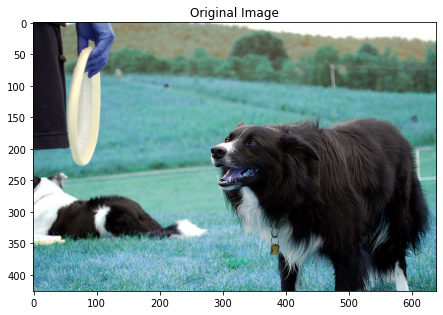

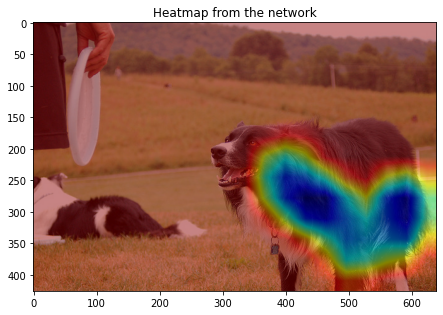

In [ ]:
#@title Visualize Model
from torchvision import models
import matplotlib.pyplot as plt
import torch
dev=  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def visual(names, model, feature_module):
  grad_cam = GradCam(model=model, feature_module=feature_module, \
                      target_layer_names=[names], use_cuda=torch.cuda.is_available())
  model.eval()

  # k='./imagenette2'
  # k1=os.listdir(k)[1:]
  # k=k+'/'+k1[np.random.randint(len(k1))]
  # k1=os.listdir(k)
  # k=k+'/'+k1[np.random.randint(len(k1))]
  # k1=os.listdir(k)
  # k=k+'/'+k1[np.random.randint(len(k1))]

  k='train2014/COCO_train2014_000000524291.jpg'
  img = cv2.imread(k, 1)

  fig=plt.figure()
  ax1 = fig.add_axes((0.1,0.4,0.8,0.5))
  ax1.set_title("Original Image")
  ax1.imshow(img)
  fig.set_size_inches(7, 8, forward=True)
  plt.show()

  img_original=img.copy()
  #plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  img = np.float32(img) / 255
  # Opencv loads as BGR:
  img = img[:, :, ::-1]
  input_img = preprocess_image(img)

  target_category = None
  grayscale_cam = grad_cam(input_img, target_category)

  grayscale_cam = cv2.resize(grayscale_cam, (img.shape[1], img.shape[0]))
  cam = show_cam_on_image(img, grayscale_cam)

  tens=model.to(dev)(input_img.to(dev))
  out=torch.softmax(tens,dim=1)
  _, indices = torch.sort(out, descending=True)


  fig=plt.figure()
  ax1 = fig.add_axes((0.1,0.4,0.8,0.5))
  ax1.set_title("Heatmap from the network")
  ax1.imshow(cam)
  fig.set_size_inches(7, 8, forward=True)
  plt.show()

  #from termcolor import colored
  #print(colored('hello', 'red'), colored('world', 'green'))
  #print(colored("\nClassification Results: \n",'green'))


  #from prettytable import PrettyTable
  #t = PrettyTable(['Class', 'Confidence'])
  #out_l=[(dict_map[idx], 100*out[0][idx].item()) for idx in indices.cpu().numpy()[0][:5]]
  #for i in out_l:
  #    t.add_row([str(i[0]),i[1]])
  #print(t)

  #tabulate(out_l,headers=['Class', 'Confidence'])

model = lstmcnn_model_pt.cnn


visual('52', model, model.features)
  

#LSTM + CNN with VGG CNN, but not Pretrained

In [ ]:
class LSTMCNN(nn.Module):
    def __init__(self, vocab_size, img_dim, dropout_p = 0.5):
        
        super(LSTMCNN, self).__init__()
        
        # initializing the layers 
        self.embedding = nn.Embedding(vocab_size, 300, padding_idx = question_vocab['<PAD>'])
        self.fc_embed = nn.Linear(300, 300)
        self.lstm = nn.LSTM(300, 512, num_layers =2, batch_first = True)
        self.fc_lstm = nn.Linear(4*512, 1024)
        self.fc_i = nn.Linear(img_dim, 1024)
        self.fc1 = nn.Linear(1024, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.dropout = nn.Dropout(dropout_p)

        self.cnn = models.vgg19_bn(pretrained = False).train().to('cuda')
        self.cnn.classifier = nn.Sequential(*list(self.cnn.classifier.children()))[:-3]
        
        # initializing weights
        self.init_weights()
 

    def forward(self, img_input, text_input):

        img_out = self.cnn(img_input)
        img_out.view(-1)

        # embedding layer: [batch_size, 25] to [batch_size, 25, 300]
        # with gelu non-linearity
        text_embedded = F.gelu(self.fc_embed(self.embedding(text_input)))
        
        # lstm layer (hidden, cell): [batch_size, 25, 300] to [2, batch_size, 512]
        _, (lstm_hidden, lstm_cell)  = self.lstm(text_embedded)

        # 4 *[batch_size, 512] to [batch_size, 2048]
        lstm_concat = torch.cat([lstm_hidden[0], lstm_hidden[1], lstm_cell[0], lstm_cell[1]], 1)
        
        # [batch_size, 2048] to [batch_size, 1024] fully connected with gelu non-linearity
        fc_lstm = self.dropout(F.gelu(self.fc_lstm(lstm_concat)))

        # Fully connected layer which embeds image into L2-normalized 1024d vector
        # [batch_size, 4096] -> [batch_size, 1024]
        fc_i = F.gelu(self.fc_i(F.normalize(img_out, dim = 1, p=2)))
        


        # point-wise multiplication of 2 [batch_size, 1024] matrices.
        pw_mul = fc_i * fc_lstm
        
        # [batch_size, 1024] to [batch_size, 1024]
        fc_1 = self.dropout(F.gelu(self.fc1(self.dropout(pw_mul))))

        # output: [batch_size, 1000]
        output = F.softmax(self.fc2(fc_1), dim=1)
        
        return output
    
    def init_weights(self):
        
        # kaiming_uniform is same as he_uniform initialization
        init = torch.nn.init.kaiming_uniform_
        for layer in self.lstm.all_weights:
            for hidden in layer[:2]:
                init(hidden)
                
        init(self.fc_embed.weight)
        init(self.fc_lstm.weight)
        init(self.fc_i.weight)
        init(self.fc1.weight)
        init(self.fc2.weight)


In [ ]:
from torch.optim import lr_scheduler

# Initializing the model with train vocab, img_dim, dropout = 0.5
lstmcnn = LSTMCNNPretrained(len(question_vocab),4096, dropout_p = 0.5)

device = torch.device('cuda:0')

# NLLLoss as loss function because we have already used softmax in last layer of model.
unk_answer_idx = answer_vocab['<UNK>'] # to ignore unknown answer index
criterion = torch.nn.NLLLoss(ignore_index = unk_answer_idx).to(device)

# Using Adamax optimizer
optimizer = torch.optim.Adamax(lstmcnn.parameters(), lr =0.001)

epochs = 20

onecycle_scheduler = lr_scheduler.OneCycleLR(optimizer, steps_per_epoch = train_dataloader.__len__(), max_lr = 0.005, epochs = epochs)

# feeding model into GPU
lstmcnn.to(device)

# setting model state to train
lstmcnn.train()

LSTMCNNPretrained(
  (embedding): Embedding(3386, 300, padding_idx=0)
  (fc_embed): Linear(in_features=300, out_features=300, bias=True)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True)
  (fc_lstm): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_i): Linear(in_features=4096, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (cnn): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [ ]:
#@title Train 
!rm -rf saved
!mkdir saved

from datetime import datetime as dt
import warnings
warnings.filterwarnings("ignore")

from torch.utils.tensorboard import SummaryWriter

cell_start = dt.now()

unk_answer_idx = answer_vocab['<UNK>']

n_batches_train = train_dataloader.__len__()
n_batches_val = val_dataloader.__len__()
train_len = train_dataloader.dataset.__len__()
val_len = val_dataloader.dataset.__len__()
train_losses = []
val_losses = []
train_accs = []
val_accs = []
cumm_val_losses = []

min_loss = 99

writer = SummaryWriter('runs/lstmcnn_model_pt')

transform = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)])

for epoch in range(epochs):
    
    start = dt.now()
    train_loss = 0
    train_correct = 0
    lstmcnn = lstmcnn.train()

    for batch, data in enumerate(train_dataloader):
        
        # unzipping data and loading it to GPU
        data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
        multi_ans = data['multi_answer']
        answers = data['answer']
        
        # zeroing the previous optimizer calculations
        optimizer.zero_grad()
        
        output = lstmcnn(data['image'], data['question'])

        data['image'], data['question'] = data['image'].cpu(), data['question'].cpu()
        
        # modifying answers tensor by replacing wrong output answers with possible multi answers.(using CPU)
        predictions = torch.argmax(output.cpu(), 1)
        indices = torch.where(~(answers == predictions))[0]
        for idx in indices:
            if predictions[idx] in multi_ans[idx]:
                answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

        loss = criterion(torch.log(output+0.000001),  answers.cuda())
        
        # backpropagating loss
        loss.backward()   
            
        optimizer.step()
        onecycle_scheduler.step()
        
        predictions[predictions == unk_answer_idx] = -1   # ignoring unknown answer
        n_corrects = (predictions == answers).sum().item()
        
        train_accs.append(n_corrects/batch_size)
        train_losses.append(loss.item()) 
        
        if(batch%100 == 99):
            writer.add_scalar('training loss',
                                train_losses[-1],
                                epoch * n_batches_train + batch)

            writer.add_scalar('training accuracy',
                                train_accs[-1],
                                epoch * n_batches_train + batch)
        
        
        train_correct += n_corrects
        train_loss += loss.item()
        
        print('\r Epoch: {}  Batches: {}/{} loss: {:.5f} acc: {:.4f}'.format(epoch+1, batch+1, n_batches_train, train_loss/(batch+1), train_correct/(min((batch+1)*batch_size, train_len))), end= '')
    
    val_correct = 0
    val_loss = 0
    with torch.no_grad():
        lstmcnn = lstmcnn.eval()
        for batch, data in enumerate(val_dataloader):
            
            data['image'], data['question'] = data['image'].to(device), data['question'].to(device)
            multi_ans = data['multi_answer']
            answers = data['answer']

            output = lstmcnn(data['image'], data['question'])

            # modifying answers tensor by replacing wrong output answers with possible multi answers.
            predictions = torch.argmax(output.cpu(), 1)
            indices = torch.where(~(answers == predictions))[0]
            for idx in indices:
                if predictions[idx] in multi_ans[idx]:
                    answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

            vloss = criterion(torch.log(output+0.000001),  answers.cuda())
            
            predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
            n_corrects_val = (predictions == answers).sum().item()
            
            val_accs.append(n_corrects_val/batch_size)
            val_losses.append(vloss.item())   
            
            val_correct += n_corrects_val
            val_loss += vloss.item()
        print(' val_loss: {:.5f} val_acc: {:.4f} [{}]'.format(val_loss/(batch+1), val_correct/(min((batch+1)*batch_size, val_len)), dt.now()-start ))
        cumm_val_losses.append(val_loss/(batch+1))
    torch.save(lstmcnn.state_dict(),'saved/model_11_state_dict')
    
    # Earlystopping with patience 5.
    if(cumm_val_losses[-1] < min_loss):
        # saving best model to disk
        torch.save(lstmcnn.state_dict(), 'saved/model_11_es_state_dict')
        min_loss = cumm_val_losses[-1]
        patience = 0
    else:
        patience += 1
        
    if(patience == 3):
        print('\n EarlyStopped. ')
        break

# saving accuracies and losses for plotting later.
with open('saved/plot_data_11.pkl','wb') as f:
    pickle.dump([n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs], f) 
    
print('\n Total time taken to run this cell: ', dt.now() - cell_start)

 Epoch: 1  Batches: 60/60 loss: 6.08905 acc: 0.2366 val_loss: 4.62070 val_acc: 0.2848 [0:02:06.926444]
 Epoch: 2  Batches: 60/60 loss: 4.37251 acc: 0.2835 val_loss: 3.92208 val_acc: 0.2848 [0:02:06.466281]
 Epoch: 3  Batches: 60/60 loss: 3.78276 acc: 0.3111 val_loss: 3.67672 val_acc: 0.3273 [0:02:06.872470]
 Epoch: 4  Batches: 60/60 loss: 3.53151 acc: 0.3455 val_loss: 3.60042 val_acc: 0.3242 [0:02:06.394245]
 Epoch: 5  Batches: 60/60 loss: 3.51084 acc: 0.3372 val_loss: 3.61664 val_acc: 0.3606 [0:02:06.576582]
 Epoch: 6  Batches: 60/60 loss: 3.32827 acc: 0.3424 val_loss: 3.55306 val_acc: 0.3606 [0:02:06.273294]
 Epoch: 7  Batches: 60/60 loss: 3.20412 acc: 0.3549 val_loss: 3.58056 val_acc: 0.3606 [0:02:06.328798]
 Epoch: 8  Batches: 60/60 loss: 3.13566 acc: 0.3502 val_loss: 3.50139 val_acc: 0.3606 [0:02:06.115715]
 Epoch: 9  Batches: 60/60 loss: 3.09231 acc: 0.3580 val_loss: 3.49724 val_acc: 0.3515 [0:02:06.106381]
 Epoch: 10  Batches: 60/60 loss: 3.05581 acc: 0.3637 val_loss: 3.57831 va

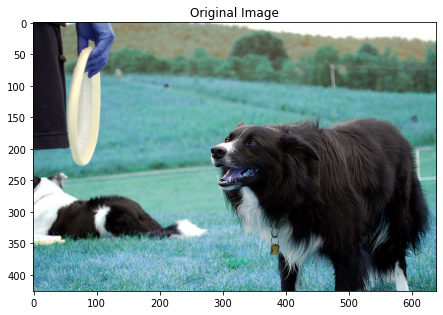

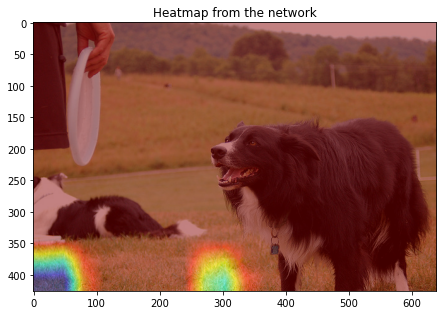

In [ ]:
#@title Visualize Model
from torchvision import models
import matplotlib.pyplot as plt
import torch
dev=  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def visual(names, model, feature_module):
  grad_cam = GradCam(model=model, feature_module=feature_module, \
                      target_layer_names=[names], use_cuda=torch.cuda.is_available())
  model.eval()

  # k='./imagenette2'
  # k1=os.listdir(k)[1:]
  # k=k+'/'+k1[np.random.randint(len(k1))]
  # k1=os.listdir(k)
  # k=k+'/'+k1[np.random.randint(len(k1))]
  # k1=os.listdir(k)
  # k=k+'/'+k1[np.random.randint(len(k1))]

  k='train2014/COCO_train2014_000000524291.jpg'
  img = cv2.imread(k, 1)

  fig=plt.figure()
  ax1 = fig.add_axes((0.1,0.4,0.8,0.5))
  ax1.set_title("Original Image")
  ax1.imshow(img)
  fig.set_size_inches(7, 8, forward=True)
  plt.show()

  img_original=img.copy()
  #plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  img = np.float32(img) / 255
  # Opencv loads as BGR:
  img = img[:, :, ::-1]
  input_img = preprocess_image(img)

  target_category = None
  grayscale_cam = grad_cam(input_img, target_category)

  grayscale_cam = cv2.resize(grayscale_cam, (img.shape[1], img.shape[0]))
  cam = show_cam_on_image(img, grayscale_cam)

  tens=model.to(dev)(input_img.to(dev))
  out=torch.softmax(tens,dim=1)
  _, indices = torch.sort(out, descending=True)


  fig=plt.figure()
  ax1 = fig.add_axes((0.1,0.4,0.8,0.5))
  ax1.set_title("Heatmap from the network")
  ax1.imshow(cam)
  fig.set_size_inches(7, 8, forward=True)
  plt.show()

  #from termcolor import colored
  #print(colored('hello', 'red'), colored('world', 'green'))
  #print(colored("\nClassification Results: \n",'green'))


  #from prettytable import PrettyTable
  #t = PrettyTable(['Class', 'Confidence'])
  #out_l=[(dict_map[idx], 100*out[0][idx].item()) for idx in indices.cpu().numpy()[0][:5]]
  #for i in out_l:
  #    t.add_row([str(i[0]),i[1]])
  #print(t)

  #tabulate(out_l,headers=['Class', 'Confidence'])

model = lstmcnn.cnn


visual('52', model, model.features)
  

#Model with LSTM, CNN, Bounding Box features

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, json_list, split):
        self.imgids = list(set([i['image_id'] for i in json_list]))
        self.split = split

    def __len__(self):
        return len(self.imgids)

    def __getitem__(self, index):
        '''
        returns 2 tensors: image features tensor, imgid tensor.
        '''
        file = self.split+'2014/COCO_'+self.split+'2014_'+str(self.imgids[index]).rjust(12, '0')+'.jpg'
        if(imghdr.what(file) == 'jpeg'):
            item = {'image': transform(Image.fromarray(jpeg.JPEG(file).decode()))}
        else:
            item = {'image': transform(Image.open(file).convert('RGB'))}

        item['id'] = self.imgids[index]
        return item

transform = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)])

def getImgBoxFeatures(workers, batch, split):

    num_workers = workers
    batch_size = batch

    box_model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True).eval().to('cuda')

    with open('train_val_lists.pkl', 'rb') as f:
        train_list, val_list = pickle.load(f)

    if(split == 'train'):
        list_json = train_list

    if(split == 'val'):
        list_json = val_list


    img_loader = DataLoader(
        ImageDataset(list_json, split),
        batch_size= batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=True,
        )

    del train_list
    del val_list
    del list_json

    box_model.eval()

    
    with h5py.File(img_loader.dataset.split+'_boxes_vgg.h5', libver='latest', mode = 'w') as f:
        box_features = f.create_dataset('box_features', shape=(len(img_loader.dataset), 4096), dtype='float16')
        box_ids = f.create_dataset('box_ids', shape=(len(img_loader.dataset),), dtype='int32')

        i = j = 0
        for data in tqdm(img_loader):
            imgs = data['image'].to('cuda')
            with torch.no_grad():
                images, _ = box_model.transform(imgs)
                out_box = box_model.backbone(images.tensors)
                out = torch.flatten(out_box['0'], 1)
                fc = nn.Linear(25600, 4096).to('cuda')
                out = fc(out)
            imgs.cpu()

            j = i + imgs.size(0)
            box_features[i:j, :] = out.cpu().numpy().astype('float16')
            box_ids[i:j] = data['id'].numpy().astype('int32')

            i = j


In [ ]:
getImgBoxFeatures(2, 32, "train")

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

100%|██████████| 60/60 [01:06<00:00,  1.11s/it]


In [ ]:
getImgBoxFeatures(2, 32, "val")

100%|██████████| 11/11 [00:12<00:00,  1.16s/it]


In [ ]:
box_feat_dict_train = {}
box_feat_dict_val = {}

box_h5 = h5py.File('train_boxes_vgg.h5', libver='latest', mode = 'r')
box_features = box_h5['box_features']
box_ids_list = list(box_h5['box_ids'])
for i in range(len(box_ids_list)):
  box_feat_dict_train[box_ids_list[i]] = box_features[i]

box_h5 = h5py.File('val_boxes_vgg.h5', libver='latest', mode = 'r')
box_features = box_h5['box_features']
box_ids_list = list(box_h5['box_ids'])
for i in range(len(box_ids_list)):
    box_feat_dict_val[box_ids_list[i]] = box_features[i]

with open('box_feats_dicts_vgg19.pickle', 'wb') as f:
    pickle.dump(box_feat_dict_train, f)
    pickle.dump(box_feat_dict_val, f)

In [ ]:
with open('train_val_lists.pkl', 'rb') as f:
    train_list, val_list = pickle.load(f)

In [ ]:
with open('vocab.pkl', 'wb') as f:
    pickle.dump([question_vocab, answer_vocab], f)

In [ ]:
class VQABoxDataset(Dataset):
    def __init__(self, json_list, question_vocab, answer_vocab, split, train_img_feats = None, val_img_feats = None, train_box_feats = None, val_box_feats = None, answer_type = None):
        self.text_data = json_list
        # based on split type, image features are initialized in the class.
        if(split == 'train'):
            self.img_feats = train_img_feats
            self.box_feats = train_box_feats
        elif(split == 'val'):
            self.img_feats = val_img_feats
            self.box_feats = val_box_feats
            if (answer_type != None):
                self.text_data = filter_dataset(json_list, answer_type)            
            
        self.questions_encoded = encode_questions(self.text_data, question_vocab)
        self.answers_encoded, self.multi_answers = encode_answers(self.text_data, answer_vocab)
        
    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, index):
        '''
        returns 3 tensors: image features tensor, encoded question tensor, encoded answer tensor.
        '''
        item = {'image': torch.tensor(self.img_feats[self.text_data[index]['image_id']].astype('float32')).view(-1)}
        item['box'] = torch.tensor(self.img_feats[self.text_data[index]['image_id']].astype('float32')).view(-1)
        item['question'] = torch.tensor(self.questions_encoded[index])
        item['answer'] = torch.tensor(self.answers_encoded[index], dtype = torch.long)
        item['multi_answer'] = torch.tensor(self.multi_answers[index], dtype = torch.long)
        return item

In [ ]:
# loading vgg pretrained features from previously saved dictionaries.
with open('img_feats_dicts_vgg19.pickle', 'rb') as f:
    img_feat_dict_train = pickle.load(f)
    img_feat_dict_val = pickle.load(f)

In [ ]:
# loading box features
with open('box_feats_dicts_vgg19.pickle', 'rb') as f:
    box_feat_dict_train = pickle.load(f)
    box_feat_dict_val = pickle.load(f)

In [ ]:
batch_size = 256

train_dataloader = DataLoader(VQABoxDataset(train_list, 
                                         question_vocab,
                                         answer_vocab,
                                         split = 'train',
                                         train_img_feats = img_feat_dict_train 
                                    ),
                                   batch_size=batch_size, shuffle = True)
val_dataloader = DataLoader(VQABoxDataset(val_list, 
                                        question_vocab,
                                        answer_vocab,
                                        split = 'val',
                                        val_img_feats = img_feat_dict_val 
                                    ),
                                   batch_size=batch_size, shuffle = False)

In [ ]:
class DeeperLSTM_QI_Box(nn.Module):
    def __init__(self, vocab_size, img_dim, dropout_p = 0.5):
        
        super(DeeperLSTM_QI_Box, self).__init__()
        
        # initializing the layers 
        self.embedding = nn.Embedding(vocab_size, 300, padding_idx = question_vocab['<PAD>'])
        self.fc_embed = nn.Linear(300, 300)
        self.lstm = nn.LSTM(300, 512, num_layers =2, batch_first = True)
        self.fc_lstm = nn.Linear(4*512, 1024)
        self.fc_i = nn.Linear(img_dim, 1024)
        self.fc1 = nn.Linear(1024, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.dropout = nn.Dropout(dropout_p)
        
        # initializing weights
        self.init_weights()
 

    def forward(self, img_feat_input, box_feat_input, text_input):

        # embedding layer: [batch_size, 25] to [batch_size, 25, 300]
        # with gelu non-linearity
        text_embedded = F.gelu(self.fc_embed(self.embedding(text_input)))
        
        # lstm layer (hidden, cell): [batch_size, 25, 300] to [2, batch_size, 512]
        _, (lstm_hidden, lstm_cell)  = self.lstm(text_embedded)

        # 4 *[batch_size, 512] to [batch_size, 2048]
        lstm_concat = torch.cat([lstm_hidden[0], lstm_hidden[1], lstm_cell[0], lstm_cell[1]], 1)
        
        # [batch_size, 2048] to [batch_size, 1024] fully connected with gelu non-linearity
        fc_lstm = self.dropout(F.gelu(self.fc_lstm(lstm_concat)))
        
        # Fully connected layer which embeds image into L2-normalized 1024d vector
        # [batch_size, 4096] -> [batch_size, 1024]
        fc_i = F.gelu(self.fc_i(F.normalize(img_feat_input, dim = 1, p=2)))
        fc_ii = F.gelu(self.fc_i(F.normalize(box_feat_input, dim = 1, p=2)))
        
        # point-wise multiplication of 2 [batch_size, 1024] matrices.
        pw_mul = fc_i * fc_lstm * fc_ii
        
        # [batch_size, 1024] to [batch_size, 1024]
        fc_1 = self.dropout(F.gelu(self.fc1(self.dropout(pw_mul))))

        # output: [batch_size, 1000]
        output = F.softmax(self.fc2(fc_1), dim=1)
        
        return output
    
    def init_weights(self):
        
        # kaiming_uniform is same as he_uniform initialization
        init = torch.nn.init.kaiming_uniform_
        for layer in self.lstm.all_weights:
            for hidden in layer[:2]:
                init(hidden)
                
        init(self.fc_embed.weight)
        init(self.fc_lstm.weight)
        init(self.fc_i.weight)
        init(self.fc1.weight)
        init(self.fc2.weight)

In [ ]:
from torch.optim import lr_scheduler

# Initializing the model with train vocab, img_dim, dropout = 0.5
bbox_model = DeeperLSTM_QI_Box(len(question_vocab),4096, dropout_p = 0.5)

device = torch.device('cuda:0')

# NLLLoss as loss function because we have already used softmax in last layer of model.
unk_answer_idx = answer_vocab['<UNK>'] # to ignore unknown answer index
criterion = torch.nn.NLLLoss(ignore_index = unk_answer_idx).to(device)

# Using Adamax optimizer
optimizer = torch.optim.Adamax(bbox_model.parameters(), lr =0.001)

epochs = 20

onecycle_scheduler = lr_scheduler.OneCycleLR(optimizer, steps_per_epoch = train_dataloader.__len__(), max_lr = 0.005, epochs = epochs)

# feeding model into GPU
bbox_model.to(device)

# setting model state to train
bbox_model.train()

DeeperLSTM_QI_Box(
  (embedding): Embedding(3386, 300, padding_idx=0)
  (fc_embed): Linear(in_features=300, out_features=300, bias=True)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True)
  (fc_lstm): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_i): Linear(in_features=4096, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
!rm -rf saved
!mkdir saved

from datetime import datetime as dt
import warnings
warnings.filterwarnings("ignore")

from torch.utils.tensorboard import SummaryWriter

cell_start = dt.now()

unk_answer_idx = answer_vocab['<UNK>']

n_batches_train = train_dataloader.__len__()
n_batches_val = val_dataloader.__len__()
train_len = train_dataloader.dataset.__len__()
val_len = val_dataloader.dataset.__len__()
train_losses = []
val_losses = []
train_accs = []
val_accs = []
cumm_val_losses = []

min_loss = 99

writer = SummaryWriter('runs/bbox_model')

for epoch in range(epochs):
    
    start = dt.now()
    train_loss = 0
    train_correct = 0
    bbox_model = bbox_model.train()

    for batch, data in enumerate(train_dataloader):
        
        # unzipping data and loading it to GPU
        data['image'], data['box'], data['question'] = data['image'].to(device), data['box'].to(device), data['question'].to(device)
        multi_ans = data['multi_answer']
        answers = data['answer']
        
        # zeroing the previous optimizer calculations
        optimizer.zero_grad()
        
        output = bbox_model(data['image'], data['box'], data['question'])
        
        # modifying answers tensor by replacing wrong output answers with possible multi answers.(using CPU)
        predictions = torch.argmax(output.cpu(), 1)
        indices = torch.where(~(answers == predictions))[0]
        for idx in indices:
            if predictions[idx] in multi_ans[idx]:
                answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

        loss = criterion(torch.log(output+0.000001),  answers.cuda())
        
        # backpropagating loss
        loss.backward()   
            
        optimizer.step()
        onecycle_scheduler.step()
        
        predictions[predictions == unk_answer_idx] = -1   # ignoring unknown answer
        n_corrects = (predictions == answers).sum().item()
        
        train_accs.append(n_corrects/batch_size)
        train_losses.append(loss.item()) 
        
        if(batch%100 == 99):
            writer.add_scalar('training loss',
                                train_losses[-1],
                                epoch * n_batches_train + batch)

            writer.add_scalar('training accuracy',
                                train_accs[-1],
                                epoch * n_batches_train + batch)
        
        
        train_correct += n_corrects
        train_loss += loss.item()
        
        print('\r Epoch: {}  Batches: {}/{} loss: {:.5f} acc: {:.4f}'.format(epoch+1, batch+1, n_batches_train, train_loss/(batch+1), train_correct/(min((batch+1)*batch_size, train_len))), end= '')
    
    val_correct = 0
    val_loss = 0
    with torch.no_grad():
        bbox_model = bbox_model.eval()
        for batch, data in enumerate(val_dataloader):
            
            data['image'], data['box'], data['question'] = data['image'].to(device), data['box'].to(device), data['question'].to(device)
            multi_ans = data['multi_answer']
            answers = data['answer']

            output = bbox_model(data['image'], data['box'], data['question'])

            # modifying answers tensor by replacing wrong output answers with possible multi answers.
            predictions = torch.argmax(output.cpu(), 1)
            indices = torch.where(~(answers == predictions))[0]
            for idx in indices:
                if predictions[idx] in multi_ans[idx]:
                    answers[idx] = multi_ans[idx][torch.where(multi_ans[idx] == predictions[idx])[0].item()]

            vloss = criterion(torch.log(output+0.000001),  answers.cuda())
            
            predictions[predictions == unk_answer_idx] = -1 #to ignore unknown answer
            n_corrects_val = (predictions == answers).sum().item()
            
            val_accs.append(n_corrects_val/batch_size)
            val_losses.append(vloss.item())   
            
            val_correct += n_corrects_val
            val_loss += vloss.item()
        print(' val_loss: {:.5f} val_acc: {:.4f} [{}]'.format(val_loss/(batch+1), val_correct/(min((batch+1)*batch_size, val_len)), dt.now()-start ))
        cumm_val_losses.append(val_loss/(batch+1))
    torch.save(bbox_model.state_dict(),'saved/model_11_state_dict')
    
    # Earlystopping with patience 5.
    if(cumm_val_losses[-1] < min_loss):
        # saving best model to disk
        torch.save(bbox_model.state_dict(), 'saved/model_11_es_state_dict')
        min_loss = cumm_val_losses[-1]
        patience = 0
    else:
        patience += 1
        
    if(patience == 3):
        print('\n EarlyStopped. ')
        break

# saving accuracies and losses for plotting later.
with open('saved/plot_data_11.pkl','wb') as f:
    pickle.dump([n_batches_train, n_batches_val, train_losses, train_accs, val_losses, val_accs], f) 
    
print('\n Total time taken to run this cell: ', dt.now() - cell_start)

 Epoch: 1  Batches: 40/40 loss: 6.83711 acc: 0.1869 val_loss: 6.64755 val_acc: 0.2900 [0:00:09.643496]
 Epoch: 2  Batches: 40/40 loss: 5.45255 acc: 0.2724 val_loss: 4.12331 val_acc: 0.2935 [0:00:09.570546]
 Epoch: 3  Batches: 40/40 loss: 4.16707 acc: 0.2814 val_loss: 3.66233 val_acc: 0.2920 [0:00:09.562668]
 Epoch: 4  Batches: 40/40 loss: 3.85269 acc: 0.3067 val_loss: 3.41729 val_acc: 0.3340 [0:00:09.615706]
 Epoch: 5  Batches: 40/40 loss: 3.68800 acc: 0.3247 val_loss: 3.30264 val_acc: 0.3520 [0:00:09.584879]
 Epoch: 6  Batches: 40/40 loss: 3.51786 acc: 0.3480 val_loss: 3.12193 val_acc: 0.3890 [0:00:09.560166]
 Epoch: 7  Batches: 40/40 loss: 3.35429 acc: 0.3717 val_loss: 2.94957 val_acc: 0.3990 [0:00:09.575580]
 Epoch: 8  Batches: 40/40 loss: 3.17102 acc: 0.3822 val_loss: 2.85665 val_acc: 0.4015 [0:00:09.585113]
 Epoch: 9  Batches: 40/40 loss: 3.04491 acc: 0.3890 val_loss: 2.81944 val_acc: 0.4070 [0:00:09.587888]
 Epoch: 10  Batches: 40/40 loss: 2.93169 acc: 0.4016 val_loss: 2.79039 va